# Kaggle 필사 노트북
## Titanic - Machine Learning from Disaster

이 노트북은 Kaggle Titanic 대회의 필사 중

> [EDA To Prediction(DieTanic)](https://www.kaggle.com/code/ash316/eda-to-prediction-dietanic)을 수행한 과정을 기록하고 있습니다.

> Google Drive + Kaggle API + GitHub 연동 기반입니다.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle_replica/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Part 1: 탐색적 데이터 분석 (EDA)
- 각 특성(변수)에 대한 분석

- 여러 특성을 함께 고려하여 관계나 경향(trend) 찾기

Part 2: 피처 엔지니어링 및 데이터 정제
- 관찰을 통해 새로운 파생 피처 생성

- 불필요한 피처 제거 또는 변환

- 예측 모델링(Predictive Modeling)에 적합한 형태로 기존 피처 변형

Part 3: 예측 모델링
- 기본적인 알고리즘 실행

- 교차 검증(Cross Validation)

- 앙상블(Ensembling, 여러 모델 결합)

- 주요 특성(feature) 추출

# Part1: Exploratory Data Analysis(EDA)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
train_path = '/content/drive/MyDrive/kaggle_replica/titanic/train.csv'
test_path = '/content/drive/MyDrive/kaggle_replica/titanic/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [6]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


Age(나이), Cabin(객실), Embarked(탑승 항구)에 결측치가 있는 것을 확인할 수 있다.

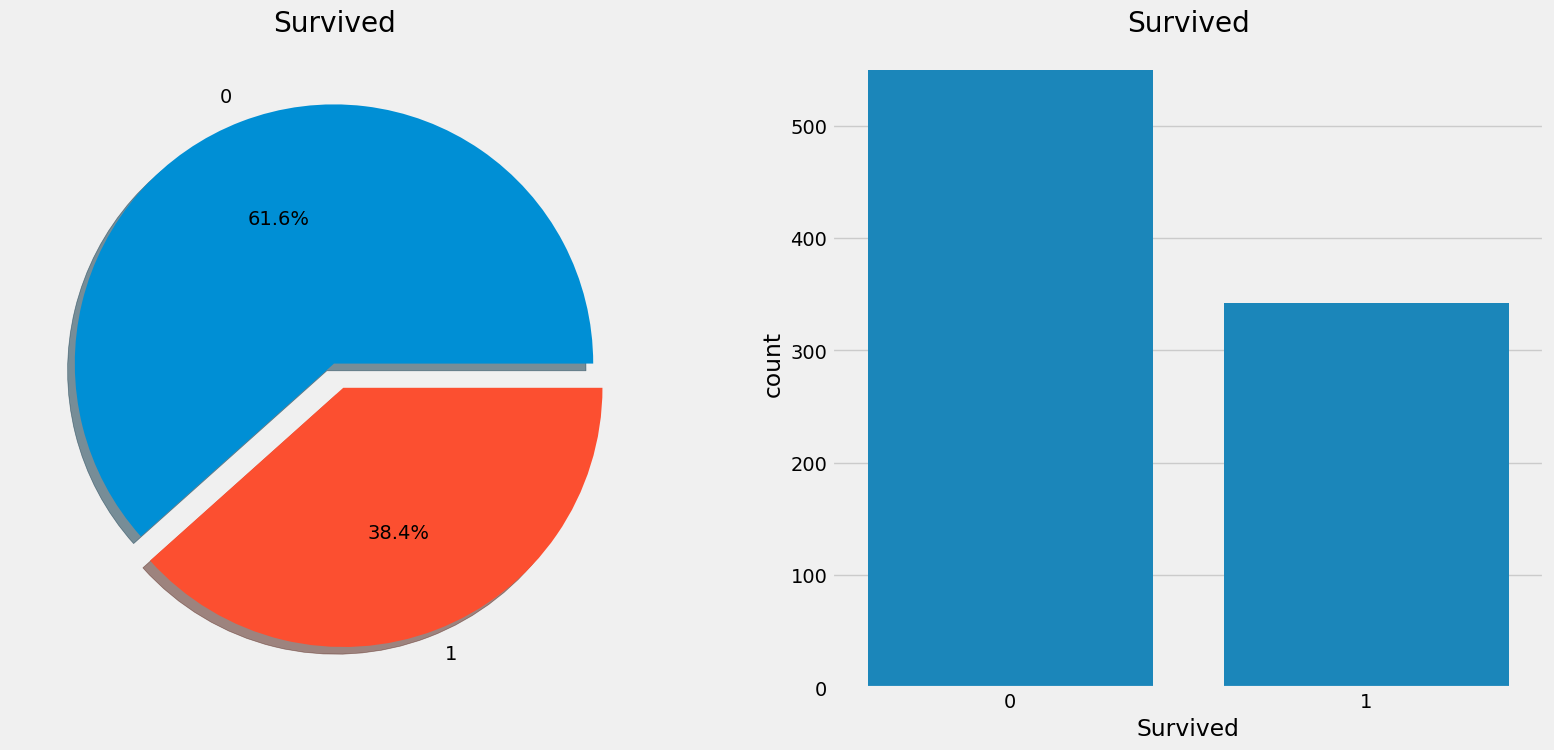

In [8]:
# 생존자(Survived) 데이터를 파악하기 위해 시각화

f, ax = plt.subplots(1, 2, figsize=(18, 8))

# (1) 파이 차트: 생존/사망 비율 시각화
train_df['Survived'].value_counts().plot.pie(
    explode=[0, 0.1],         # 두 번째 조각(생존자)을 약간 분리
    autopct='%1.1f%%',
    ax=ax[0],
    shadow=True
)
ax[0].set_title('Survived')
ax[0].set_ylabel('')

# (2) 카운트 플롯: 생존 여부에 따른 인원수 시각화
sns.countplot(x='Survived', data=train_df, ax=ax[1])
ax[1].set_title('Survived')

plt.show()


### 데이터 및 피처 확인
사고에서 생존한 승객이 많지 않다는 것은 명백하다.

훈련 데이터셋에 포함된 891명의 승객 중 약 350명만 생존했으며, 이는 전체의 약 38.4%만이 생존했다는 의미이다.

이 데이터를 분석하여 어떤 승객들이 생존했으며, 누가 생존하지 못했는지 더 나은 인사이트를 얻어야 한다.

이를 위해, 데이터셋에 있는 다양한 feature들을 활용하여 생존율을 특성별로 나누어 살펴볼 예정이다.

<br>

### 피처 유형 확인
**범주형(Categorical) 피처**
- 범주형 변수는 두 개 이상의 범주(category) 를 가지며
- 각 값이 그 중 하나의 범주로 분류될 수 있는 변수이다.

- 예를 들어, 성별(Sex)은 두 가지 범주인 남성(male)과 여성(female)을 가지며,
이 변수는 정렬하거나 순서를 매길 수 없다.

- 데이터셋 내 범주형 변수: Sex, Embarked

**순서형(Ordinal) 피처**
- 순서형 변수는 범주형 변수와 비슷하지만,
값들 사이에 상대적인 순서(정렬 가능) 가 존재한다.

- 예를 들어, 키(Height)라는 변수에 Tall, Medium, Short와 같은 값이 있다면,
이 변수는 상대적인 높낮이를 기반으로 정렬할 수 있으므로 순서형 변수이다.

- 데이터셋 내 순서형 변수: Pclass (객실 등급)

**연속형(Continuous) 피처**
- 연속형 변수는 값들이 연속적인 구간을 가질 수 있는 변수이다.
- 즉, 최솟값과 최댓값 사이에 모든 값이 존재할 수 있는 변수이다.

- 데이터셋 내 연속형 변수: Age (나이)

## Sex--> Categorical Feature

In [9]:
train_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

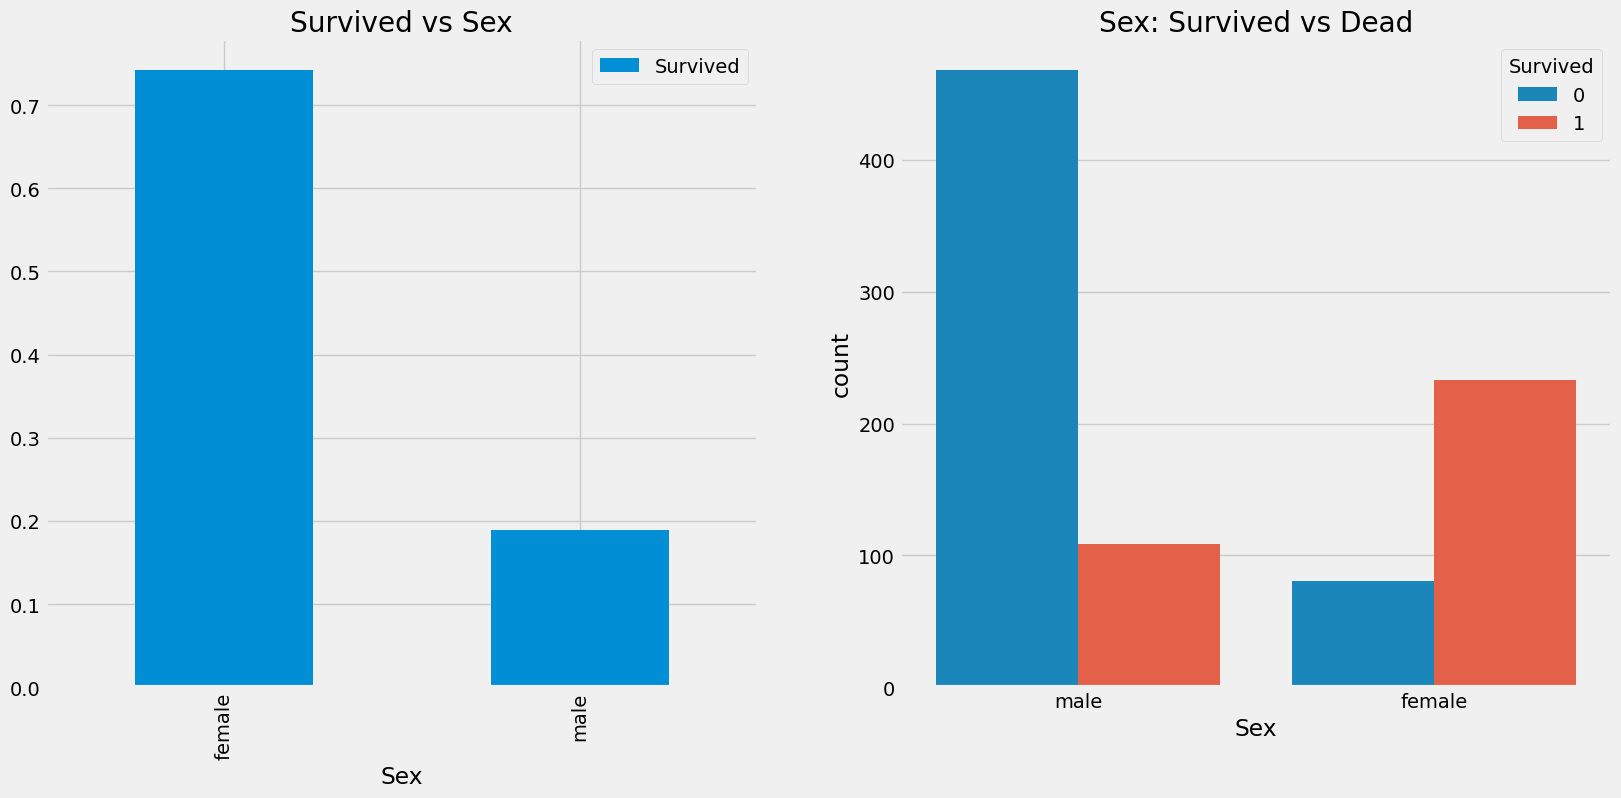

In [10]:
# 성별에 따른 생존율과 생존/사망 인원수 시각화
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# (1) 성별 그룹에 따라 평균 생존율 계산하여 막대그래프로 출력
train_df[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')

# (2) 성별과 생존 여부에 따라 분류된 카운트플롯 시각화
sns.countplot(x='Sex', hue='Survived', data=train_df, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')

plt.show()


선박에 탑승한 남성의 수가 여성보다 훨씬 많았음을 볼 수 있다. 그런데도 구조된 여성의 수는 구조된 남성의 수의 거의 두 배에 달한다.  
배에 탑승한 여성의 생존률은 약 75%인 반면, 남성의 생존률은 약 18~19% 정도인데 이는 모델링에 있어 매우 중요한 feature로 보인다.

하지만 과연 이것이 가장 중요한 특성일까? 다른 특성들도 확인해 보자.



## Pclass --> Ordinal Feature

In [11]:
# Pclass와 Survived의 교차 테이블을 생성하여 생존 여부와 승객 클래스 간의 관계 분석
# margins=True는 'All' 행과 열을 추가하여 각 클래스와 생존 여부의 합계를 제공
pd.crosstab(train_df.Pclass, train_df.Survived, margins=True) \
    .style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


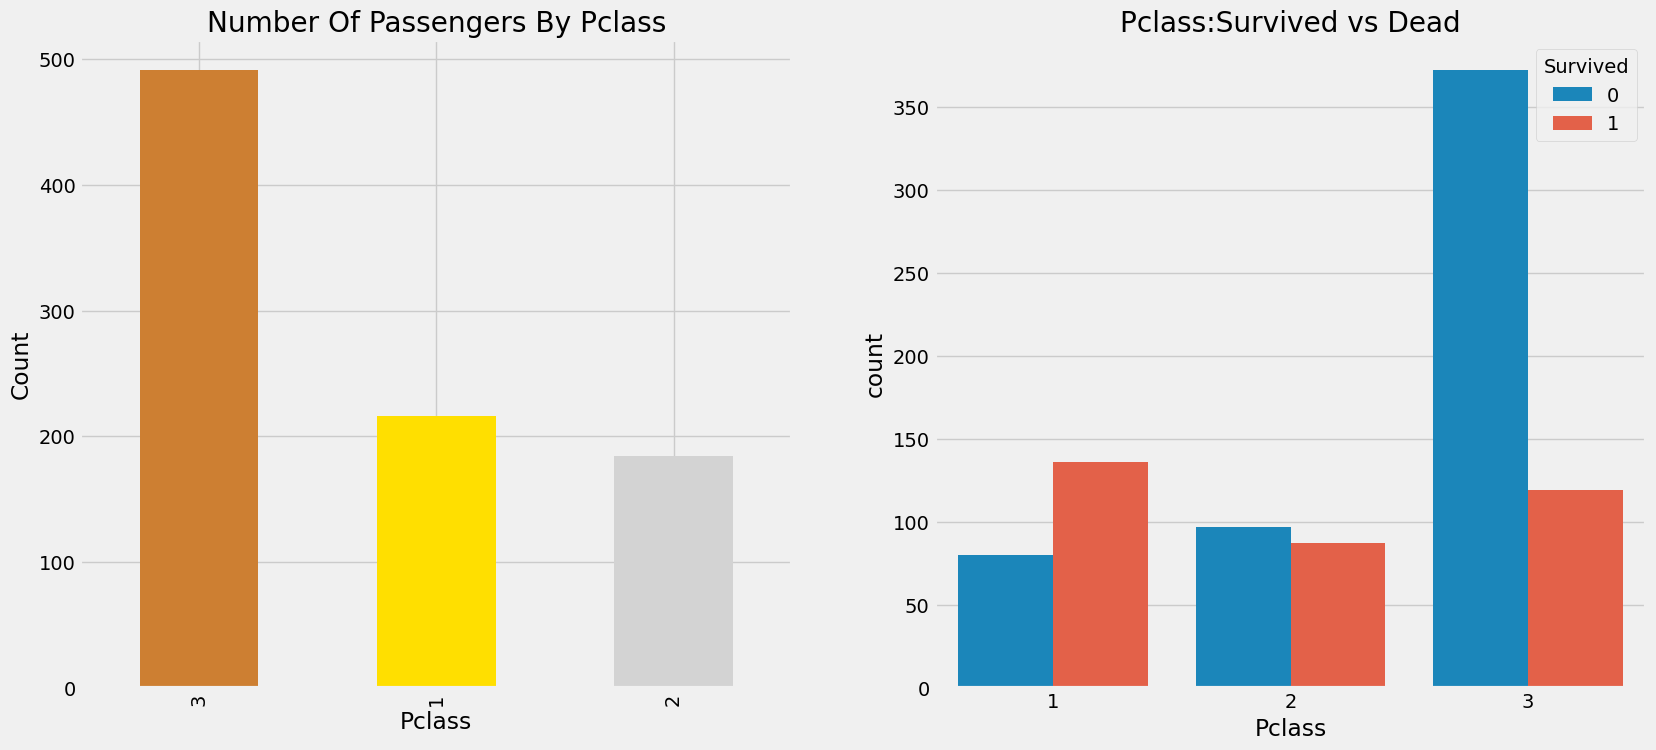

In [12]:
# 승객 등급(Pclass)에 따른 탑승자 수와 생존자 수 분포 비교

f, ax = plt.subplots(1, 2, figsize=(18, 8))

# (1) 등급별 전체 탑승자 수 시각화
train_df['Pclass'].value_counts().plot.bar(
    color=['#CD7F32', '#FFDF00', '#D3D3D3'],
    ax=ax[0]
)
ax[0].set_title('Number Of Passengers By Pclass')
ax[0].set_ylabel('Count')

# (2) 등급별 생존/사망 인원 분포 시각화
sns.countplot(x='Pclass', hue='Survived', data=train_df, ax=ax[1])
ax[1].set_title('Pclass:Survived vs Dead')

plt.show()



1등석(Pclass 1) 승객들은 구조될 때 매우 높은 우선순위를 받았다는 것을 볼 수 있다.

3등석(Pclass 3) 승객의 수는 훨씬 많았지만, 생존자는 매우 적었고 생존률은 약 25% 정도에 불과했다.

1등석 승객의 생존률은 약 63%, 2등석은 약 48%였다.

<br>

이번엔 성별(Sex)과 객실 등급(Pclass) 을 동시에 고려한 생존률을 확인해 보자.

In [13]:
pd.crosstab([train_df.Sex, train_df.Survived], train_df.Pclass,margins=True).style.background_gradient(cmap='summer_r')

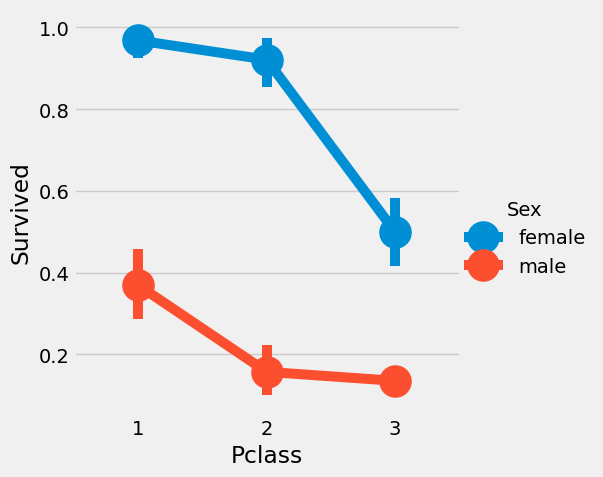

In [14]:
# 성별(Sex)과 객실 등급(Pclass)에 따른 생존률을 시각화하는 포인트 그래프

sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train_df, kind='point')
plt.show()

범주형 변수 간의 구분을 시각적으로 확인하기 위해 catplot를 사용하였다.

CrossTab과 FactorPlot을 보면, 1등석 여성의 생존률이 약 95~96%에 달한다는 사실을 쉽게 알 수 있다. 1등석 여성 94명 중 단 3명만 사망했기 때문이다.

객실 등급(Pclass)과 관계없이 여성들이 구조 시 최우선 순위를 받았다는 것이 분명하다. 심지어 1등석 남성들도 생존률이 매우 낮았다.

Pclass도 중요한 특성(feature)처럼 보인다.


## Age--> Continous Feature

In [15]:
# 탑승자 중 가장 나이 많은 사람, 가장 어린 사람, 평균 나이 출력

print(f'Oldest Passenger was of: {train_df["Age"].max():.1f} Years')
print(f'Youngest Passenger was of: {train_df["Age"].min():.1f} Years')
print(f'Average Age on the ship: {train_df["Age"].mean():.1f} Years')

Oldest Passenger was of: 80.0 Years
Youngest Passenger was of: 0.4 Years
Average Age on the ship: 29.7 Years


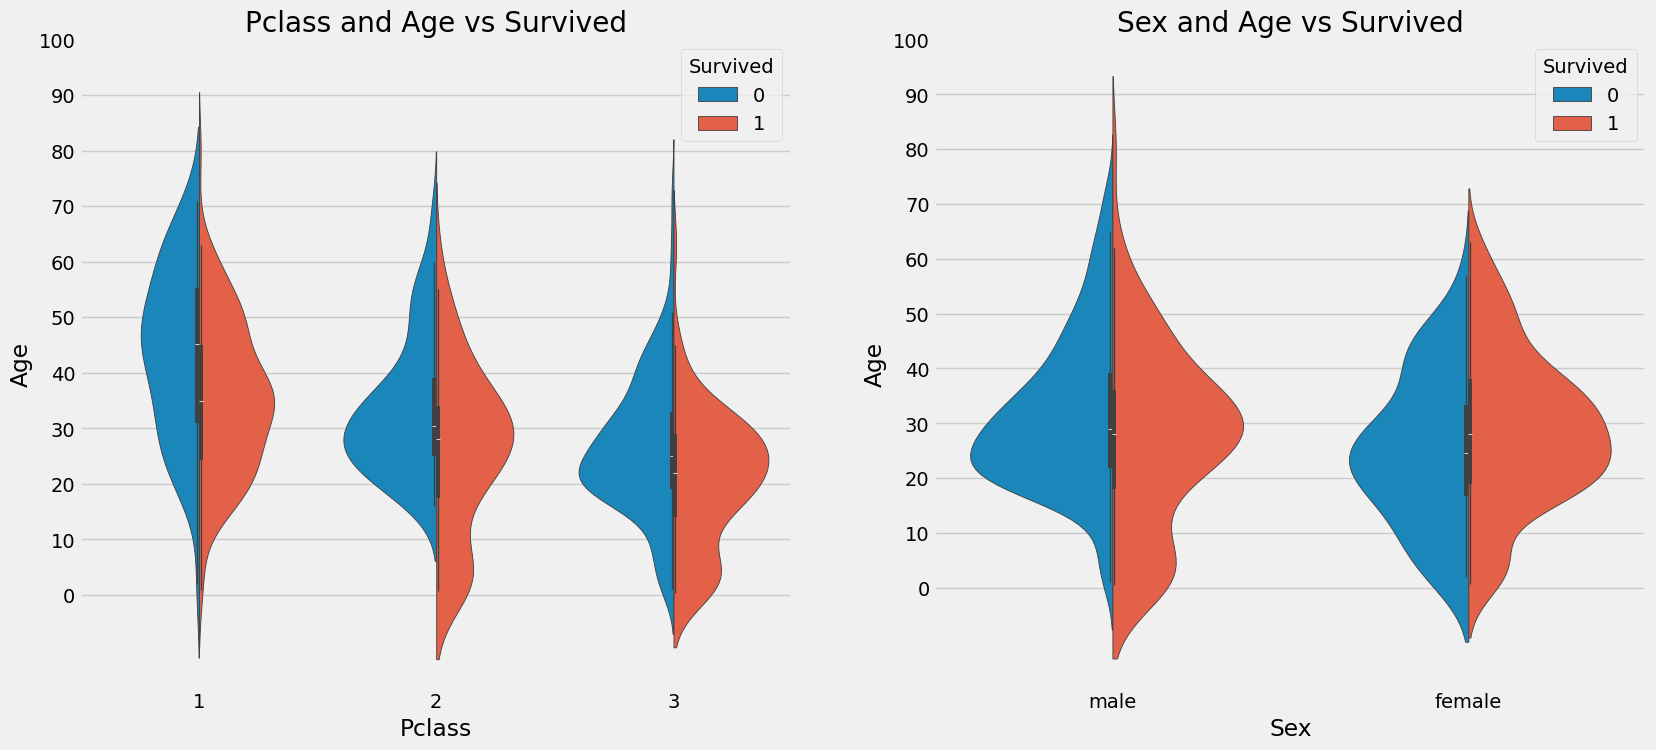

In [16]:
# 나이(Age)를 기준으로 객실 등급(Pclass) 및 성별(Sex)과 생존 여부(Survived)의 관계 비교

f, ax = plt.subplots(1, 2, figsize=(18, 8))

# (1) 객실 등급별 생존 여부에 따른 나이 분포 시각화
sns.violinplot(x='Pclass', y='Age', hue='Survived', data=train_df, split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10))

# (2) 성별별 생존 여부에 따른 나이 분포 시각화
sns.violinplot(x='Sex', y='Age', hue='Survived', data=train_df, split=True, ax=ax[1])
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))

plt.show()


관찰 결과 (Observations)
1. 어린이의 수는 Pclass가 높아질수록 증가하며, 나이 10세 이하의 승객(어린이)의 생존률은 Pclass와 상관없이 높아 보인다.
2. Pclass 1에 속한 20~50세 승객들의 생존률은 높고, 특히 여성일수록 더 높다.
3. 남성의 경우, 나이가 많아질수록 생존 가능성이 감소하는 경향이 있다.

<br>

Age 컬럼의 결측치(NaN) 처리
- 앞서 확인했듯이 Age 특성에는 177개의 결측값 이 존재한다.
이 NaN 값을 대체하기 위해 단순히 평균 나이로 채울 수도 있겠지만, 문제는 사람마다 나이가 매우 다양하다는 것이다.

<br>

그렇다면 승객이 어떤 나이대(Age Band)에 속해 있는지를 알아낼 방법이 없을까?

Name이라는 특성을 살펴보면, 이름에 'Mr', 'Mrs'와 같은 호칭(salutation)이 포함되어 있다는 걸 알 수 있다.

-> Mr, Mrs, Miss, Master 등의 호칭별로 평균 나이를 구해, 해당 그룹에 속한 사람들의 NaN 값을 그 평균으로 대체할 수 있다.


In [17]:
# 이름(Name)에서 호칭(Mr, Mrs 등)을 추출해 'Initial' 컬럼에 저장

train_df['Initial'] = 0

# 정규표현식을 활용해 이름에서 마침표(.) 앞의 알파벳만 추출
train_df['Initial'] = train_df.Name.str.extract('([A-Za-z]+)\.')

In [18]:
# 호칭(Initial)과 성별(Sex) 간의 관계를 교차표로 확인

# 행/열 전치: 성별을 행, 호칭을 열로 보기 좋게 전환
pd.crosstab(train_df.Initial, train_df.Sex).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


좋아요, Mlle 또는 Mme처럼 잘못 표기된 호칭(Initial) 들이 있는데, 이들은 사실상 Miss를 의미한다.

따라서 이들을 Miss로 교체할 것이며, 다른 호칭들도 같은 방식으로 정리한다.



In [19]:
train_df['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],inplace=True)

In [20]:
# 호칭(Initial)별 나이(Age 평균 계산
train_df.groupby('Initial')['Age'].mean()

,Age
Initial,
Master,4.574167
Miss,21.860000
Mr,32.739609
Mrs,35.981818
Other,45.888889


이 평균값을 기준으로 Age의 NaN을 채운다.

In [21]:
# 호칭(Initial)별 평균 나이를 기준으로 Age의 결측값(NaN) 채우기
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Mr'),'Age']=33
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Mrs'),'Age']=36
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Master'),'Age']=5
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Miss'),'Age']=22
train_df.loc[(train_df.Age.isnull())&(train_df.Initial=='Other'),'Age']=46

In [22]:
train_df.Age.isnull().any()

np.False_

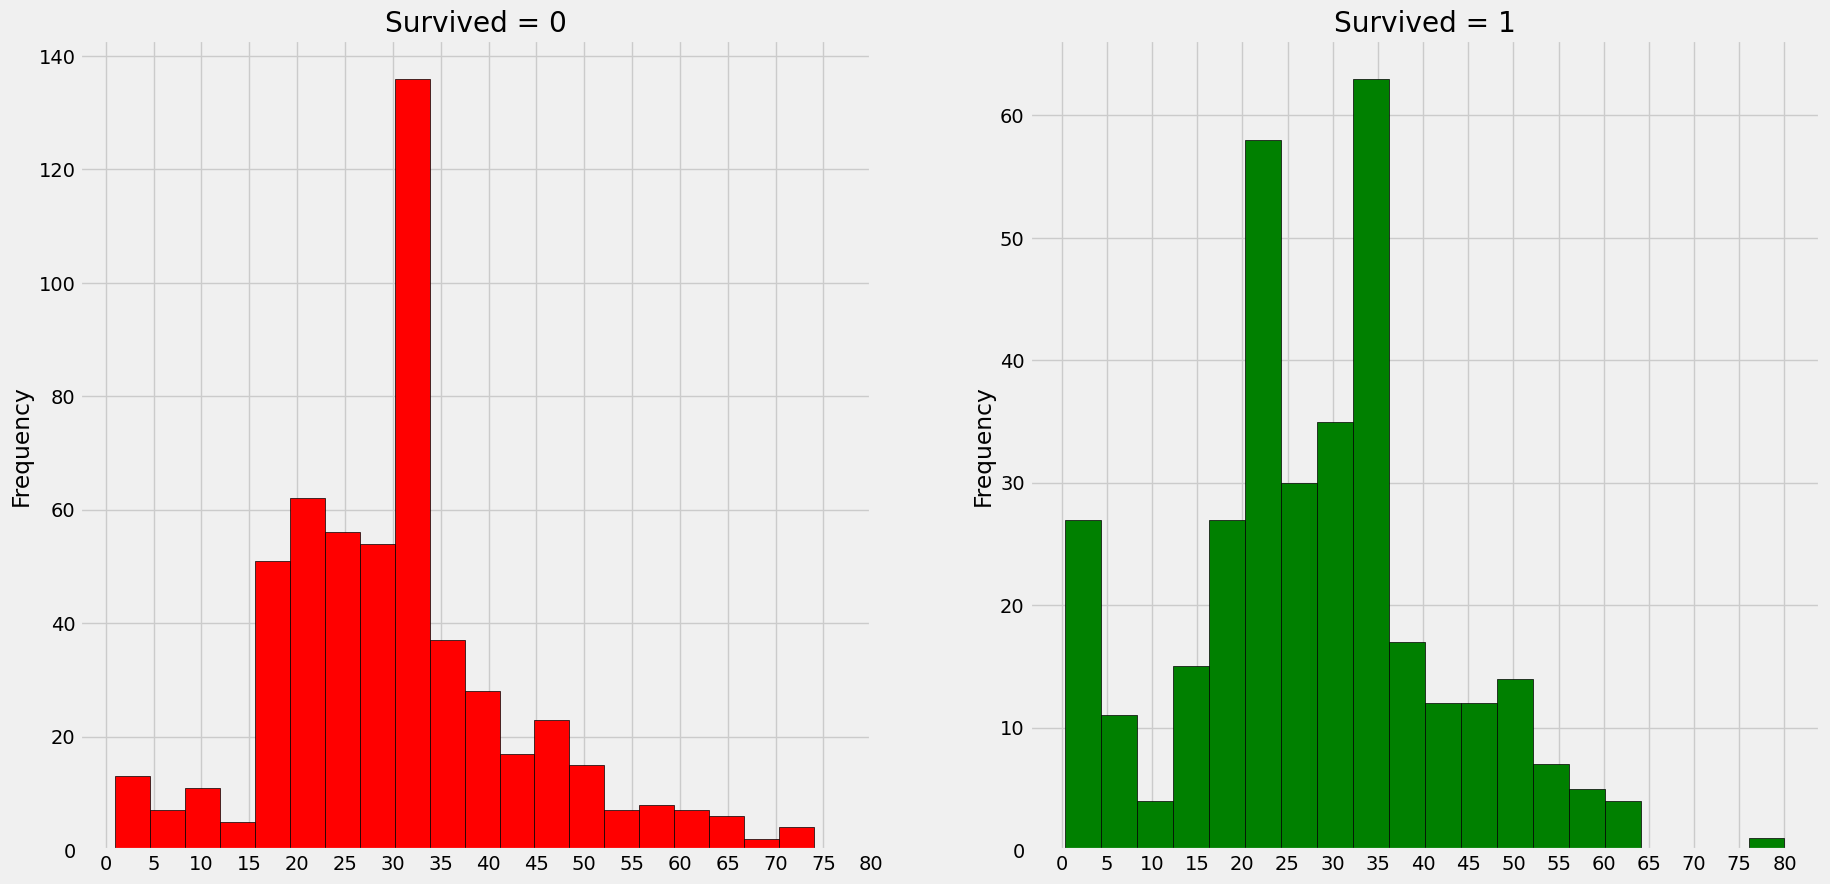

In [23]:
# 생존 여부(Survived)에 따른 승객 나이(Age) 분포를 히스토그램으로 비교

f, ax = plt.subplots(1, 2, figsize=(20, 10))

# (1) 사망자(Survived = 0)의 나이 분포
train_df[train_df['Survived'] == 0].Age.plot.hist(
    ax=ax[0],
    bins=20,  # 구간 개수
    edgecolor='black',
    color='red'
)
ax[0].set_title('Survived = 0')
x1 = list(range(0, 85, 5))
ax[0].set_xticks(x1)

# (2) 생존자(Survived = 1)의 나이 분포
train_df[train_df['Survived'] == 1].Age.plot.hist(
    ax=ax[1],
    bins=20,
    edgecolor='black',
    color='green'
)
ax[1].set_title('Survived = 1')
x2 = list(range(0, 85, 5))
ax[1].set_xticks(x2)

plt.show()

#### 관찰 결과 (Observations)
1. 5세 미만의 유아(Toddlers) 들은 다수 구조되었다.  
→ 이는 “여성과 어린이 우선 구조 정책(Women and Child First)”의 영향으로 보인다.

2. 가장 나이가 많은 탑승객(80세) 도 구조되었다.  
→ 고령자라도 일부 구조된 사례가 있었음을 보여준다.

3. 가장 많은 사망자 수는 30~40세 연령대에서 발생하였다.  
→ 중장년층 남성 등에서 생존률이 낮았던 것으로 해석 가능하다.


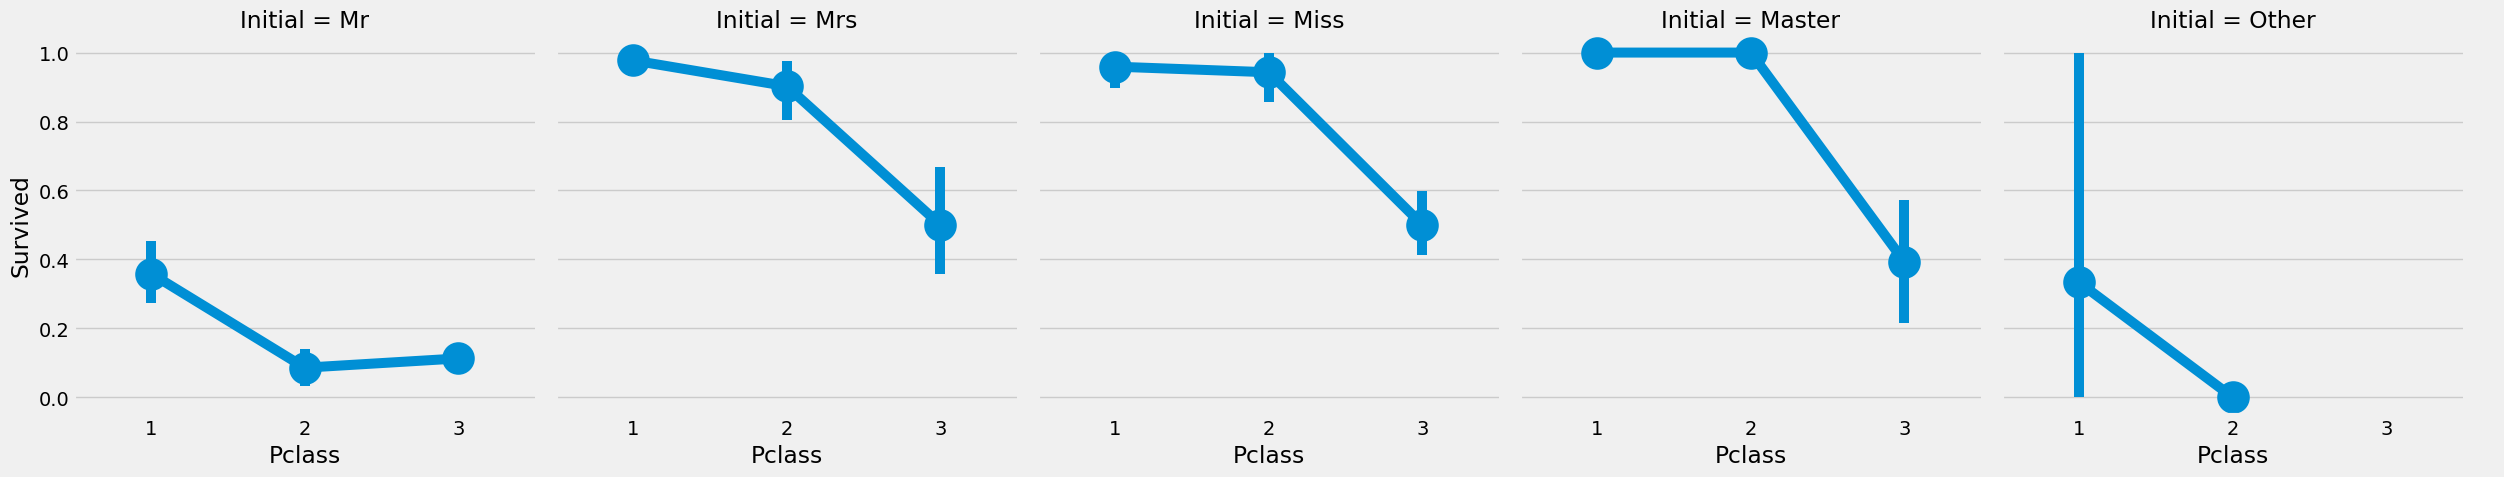

In [24]:
# 객실 등급(Pclass)과 생존 여부(Survived)의 관계를 호칭(Initial)별로 나누어 시각화
sns.catplot(x='Pclass', y='Survived', col='Initial', data=train_df, kind='point')
plt.show()

여성과 어린이를 우선 구조하는 정책은 객실 등급과 관계없이 유효했음을 알 수 있다.

## Embarked--> Categorical Value

In [25]:
# 탑승항구(Embarked)와 객실 등급(Pclass)별로
# 성별(Sex)과 생존 여부(Survived)에 따른 승객 수를 교차표로 정리

pd.crosstab(
    [train_df.Embarked, train_df.Pclass],    # 행: 탑승항구 + 객실 등급 조합
    [train_df.Sex, train_df.Survived],       # 열: 성별 + 생존 여부 조합
    margins=True
).style.background_gradient(cmap='summer_r')

탑승 항구(Embarked)에 따라 생존률이 어떻게 달라지는지 살펴보자.

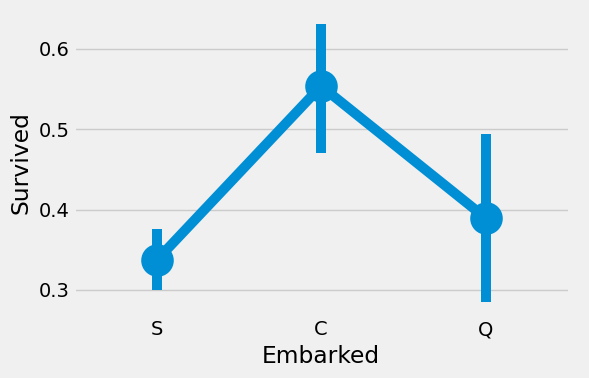

In [26]:
# 탑승 항구(Embarked)에 따라 생존률(Survived)이 어떻게 달라지는지 비교

sns.catplot(x='Embarked', y='Survived', data=train_df, kind='point', height=4, aspect=1.5)
plt.show()


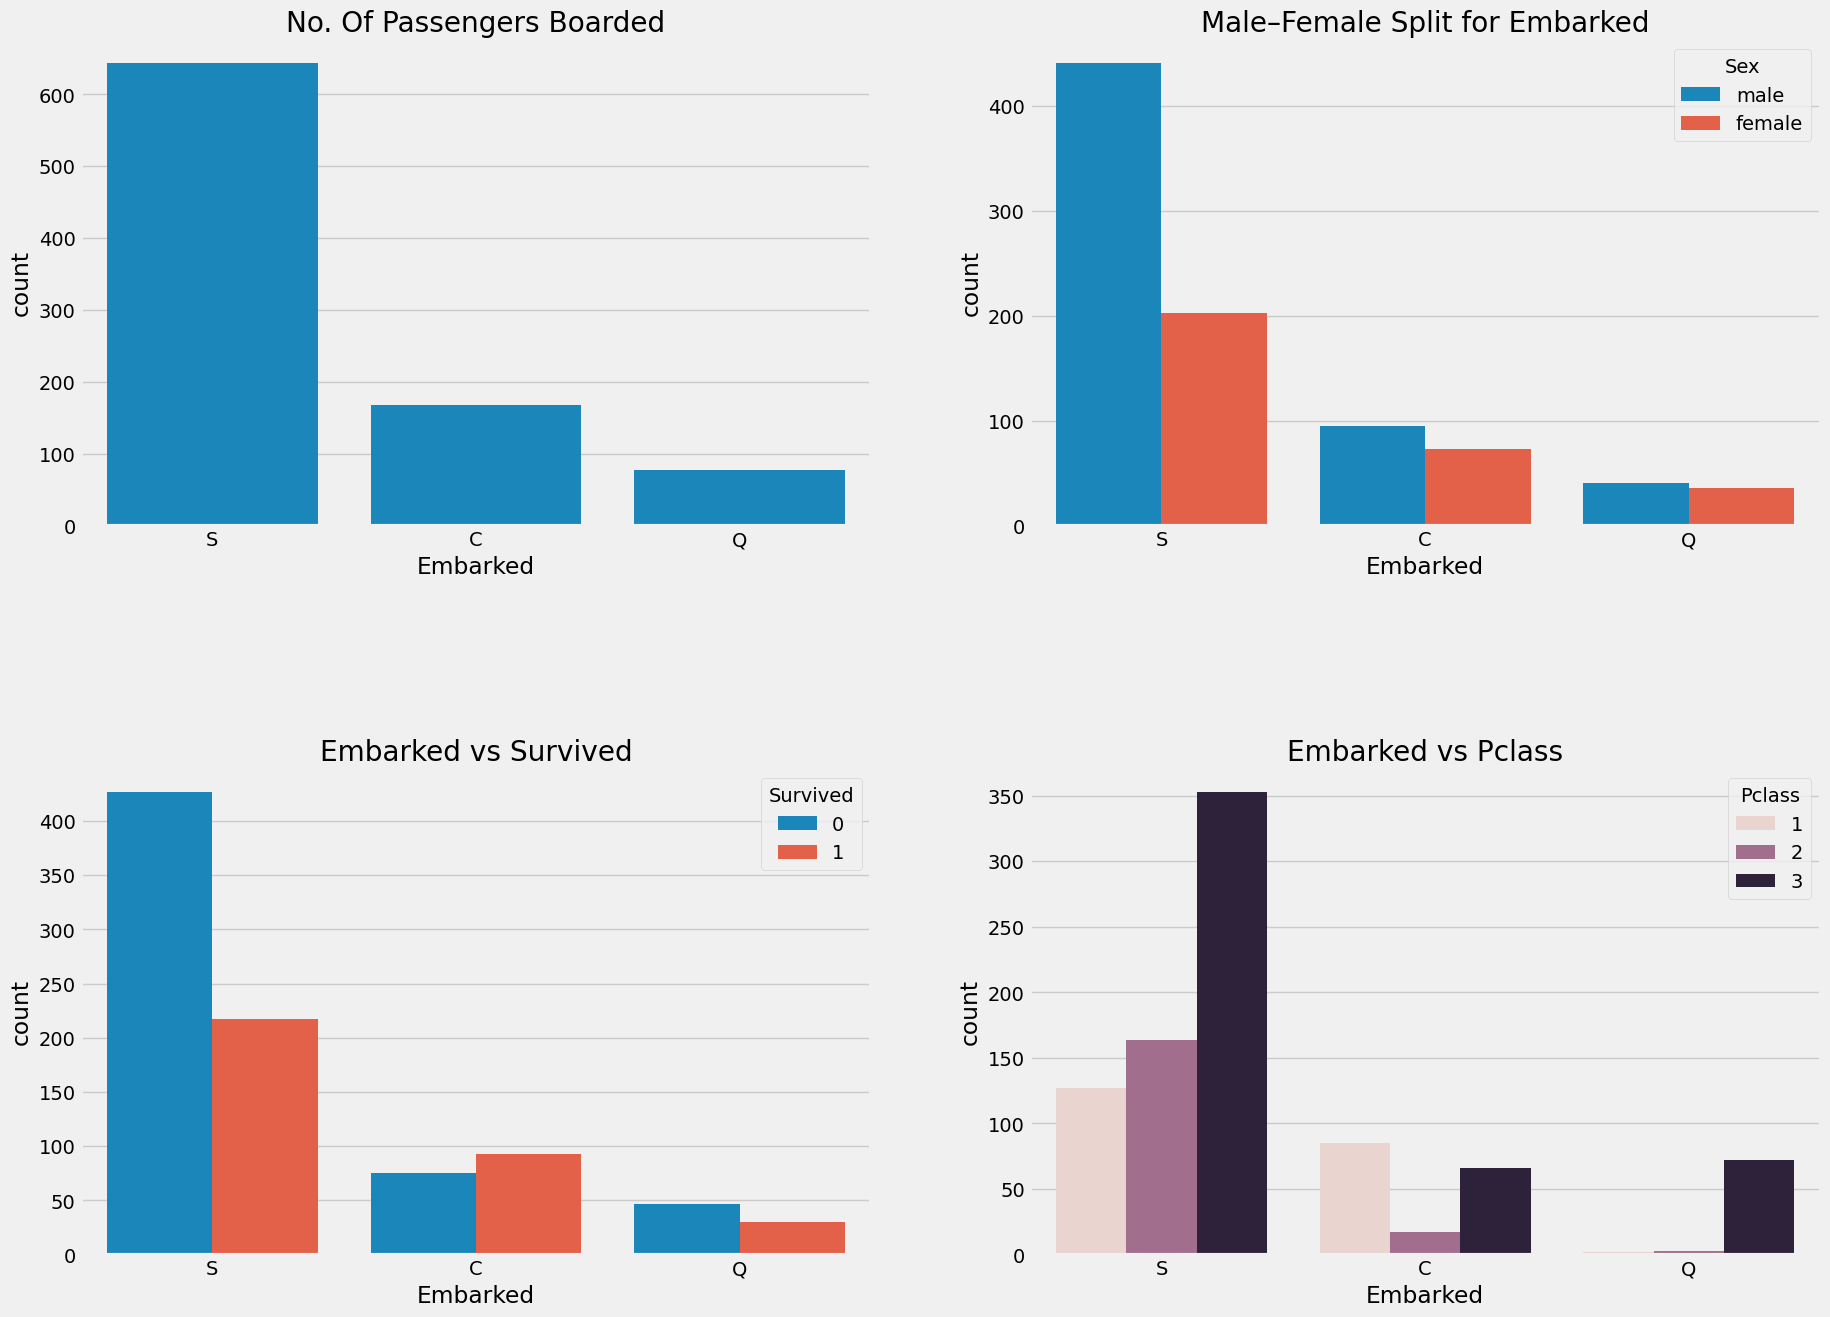

In [27]:
# 탑승 항구(Embarked)와 성별, 생존 여부, 객실 등급 간의 관계 비교

f, ax = plt.subplots(2, 2, figsize=(20, 15))

# (1) 각 탑승 항구에서 탑승한 승객 수
sns.countplot(x='Embarked', data=train_df, ax=ax[0, 0])
ax[0, 0].set_title('No. Of Passengers Boarded')

# (2) 탑승 항구별 성별 분포
sns.countplot(x='Embarked', hue='Sex', data=train_df, ax=ax[0, 1])
ax[0, 1].set_title('Male–Female Split for Embarked')

# (3) 탑승 항구별 생존 여부 분포
sns.countplot(x='Embarked', hue='Survived', data=train_df, ax=ax[1, 0])
ax[1, 0].set_title('Embarked vs Survived')

# (4) 탑승 항구별 객실 등급(Pclass) 분포
sns.countplot(x='Embarked', hue='Pclass', data=train_df, ax=ax[1, 1])
ax[1, 1].set_title('Embarked vs Pclass')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

#### 관찰 결과 (Observations)

1. S 항구에서 탑승한 승객이 가장 많았으며, 이들 중 다수는 3등석(Pclass3) 승객이었다.
2. C 항구에서 탑승한 승객들은 운이 좋았던 것처럼 보인다.
    
    그 이유는 생존한 비율이 높았기 때문인데, 이는 대부분 1등석과 2등석 승객들이 구조되었기 때문일 가능성이 있다.
    
3. S 항구는 부유한 승객들이 많이 탑승한 항구처럼 보이지만, 생존률은 낮았다.
    
    이는 S 항에서 탑승한 많은 3등석 승객들 중 약 81%가 생존하지 못했기 때문이다.
    
4. Q 항구에서 탑승한 승객 중 약 95%가 3등석이었다.

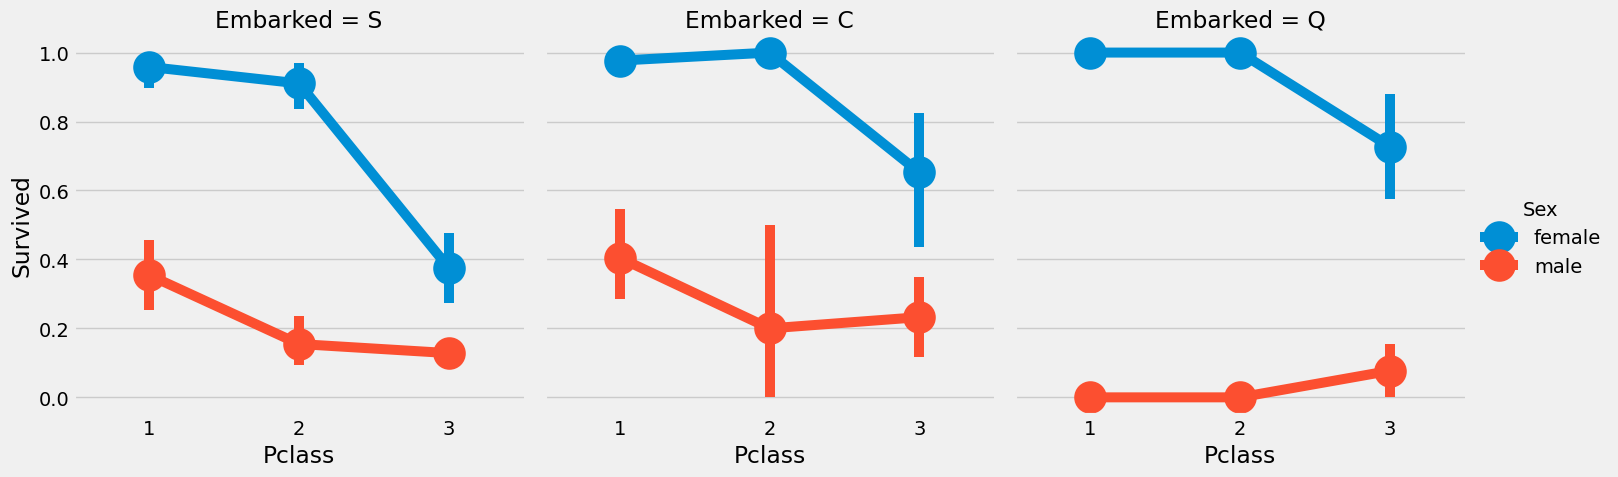

In [28]:
# 탑승 항구(Embarked)별로 객실 등급(Pclass)과 성별(Sex)에 따른 생존률(Survived)을 포인트 플롯으로 시각화

sns.catplot(
    x='Pclass',          # 객실 등급
    y='Survived',        # 생존률
    hue='Sex',           # 성별에 따라 선 구분
    col='Embarked',      # 탑승 항구별로 subplot 분리
    data=train_df,
    kind='point',        # 평균값을 점과 선으로 표시
    height=5, aspect=1
)
plt.show()

#### 관찰 결과 (Observations)

1. 여성의 생존률은 Pclass1과 Pclass2 모두에서 거의 1에 가까울 정도로 높았다.
    
    → 객실 등급에 관계없이 여성은 우선적으로 구조되었음을 보여준다.
    
2. S 항구에서 탑승한 Pclass3 승객들은 매우 운이 없었던 것으로 보인다.
    
    → 남성과 여성 모두 생존률이 매우 낮았으며,
    
    이는 '돈이 중요하다(Money Matters)'는 현실을 보여준다.
    
3. Q 항구는 특히 남성들에게 가장 불운한 항구였다.
    
    → 그 이유는 거의 모든 승객이 Pclass3에 속했기 때문이다.

이 시점에서 탑승 항구 + 객실 등급 + 성별의 조합이 생존률에 얼마나 큰 영향을 미치는지
정확하게 파악할 수 있다.

<br>

Embarked 컬럼의 NaN 값 채우기

→ 앞서 확인했듯, 대부분의 승객은 S 항구에서 탑승했기 때문에, 결측값(NaN)은 'S'로 대체한다.

In [29]:
train_df['Embarked'].fillna('S',inplace=True)

In [30]:
train_df.Embarked.isnull().any()

np.False_

## SibSip-->Discrete Feature

이 특성(feature)은 해당 승객이 혼자인지, 아니면 가족과 함께 탑승했는지를 나타낸다.

- 형제자매 = 형, 누나, 오빠, 여동생, 의붓형제자매  
- 배우자 = 남편, 아내

In [31]:
pd.crosstab([train_df.SibSp], train_df.Survived).style.background_gradient(cmap='summer_r')

Survived,0,1
SibSp,,
0,398,210
1,97,112
2,15,13
3,12,4
4,15,3
5,5,0
8,7,0


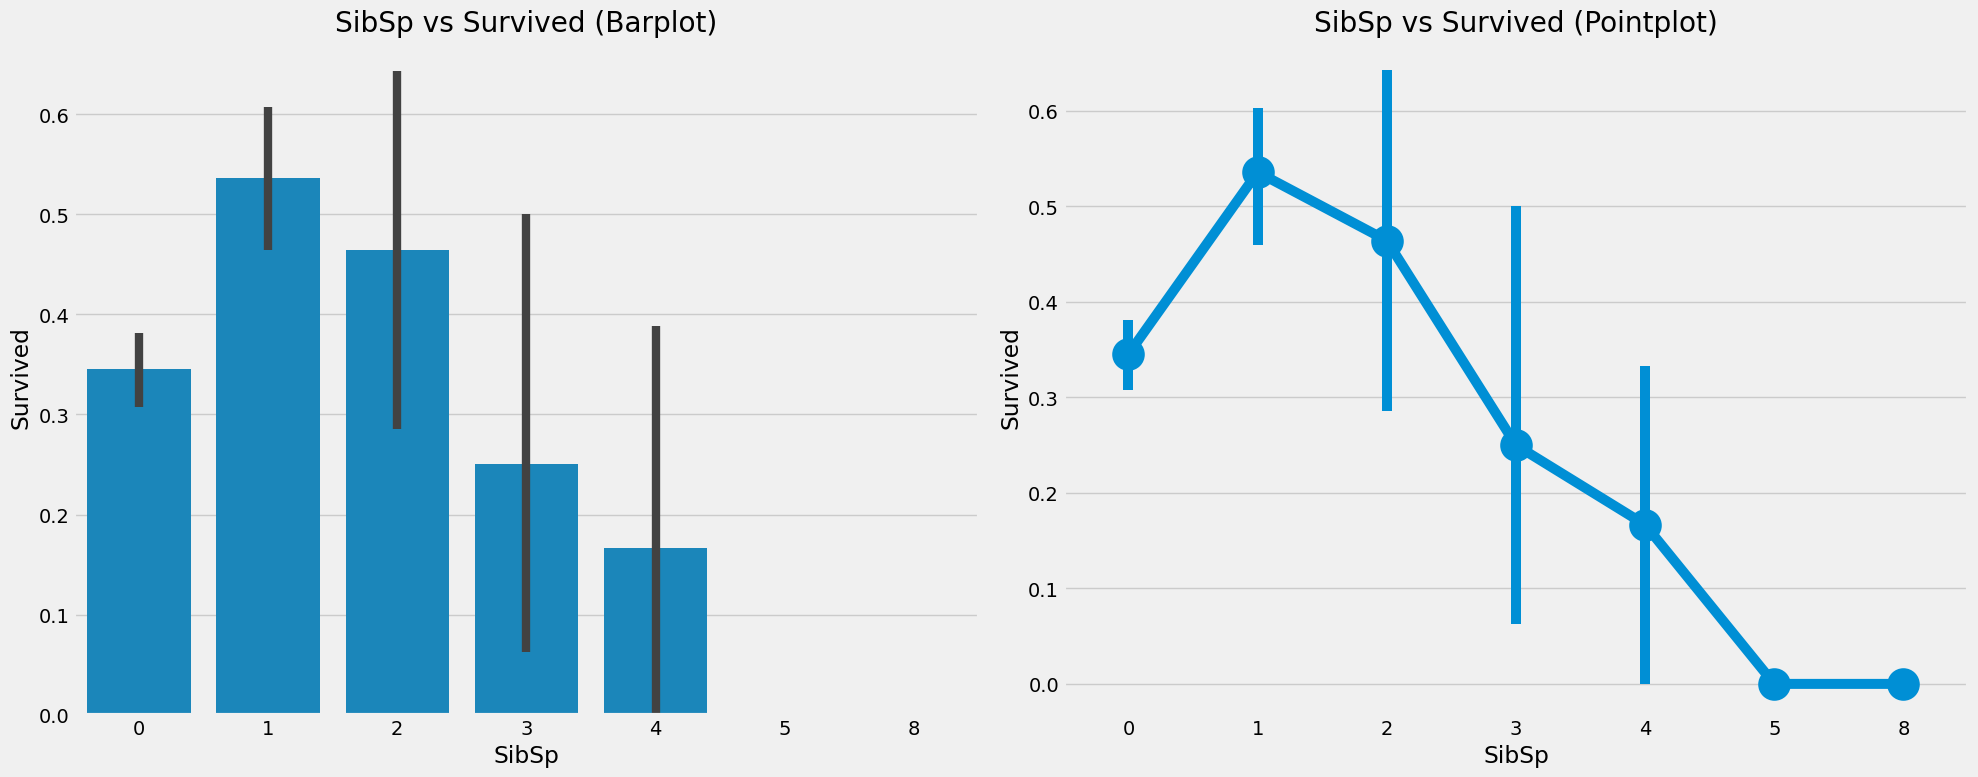

In [32]:
# SibSp(형제자매/배우자 수)에 따라 생존률이 어떻게 달라지는지 비교

f, ax = plt.subplots(1, 2, figsize=(20, 8))

# (1) 막대그래프: SibSp 수에 따른 평균 생존률
sns.barplot(x='SibSp', y='Survived', data=train_df, ax=ax[0])
ax[0].set_title('SibSp vs Survived (Barplot)')

# (2) 포인트그래프: 선과 점으로 평균 생존률 표현 (factorplot 대체)
# sns.catplot()은 별도 figure 생성 → subplot 배치에는 적합하지 않다.
sns.pointplot(x='SibSp', y='Survived', data=train_df, ax=ax[1])
ax[1].set_title('SibSp vs Survived (Pointplot)')

plt.tight_layout()
plt.show()

In [33]:
pd.crosstab(train_df.SibSp, train_df.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
SibSp,,,
0,137,120,351
1,71,55,83
2,5,8,15
3,3,1,12
4,0,0,18
5,0,0,5
8,0,0,7


#### 관찰 결과 (Observations)

1. 막대그래프(barplot)와 포인트그래프(pointplot)에 따르면,
    
    혼자 탑승한 승객(SibSp=0)의 생존률은 약 34.5%로 나타난다.
    
2. 형제자매/배우자 수가 많아질수록 생존률은 점점 감소하는 경향을 보인다.
    
    이는 논리적으로도 이해된다.
    
    예를 들어, 가족과 함께 탑승했다면, 자신보다 가족을 먼저 구하려 할 수도 있기 때문이다.
    
3. 특히 SibSp가 5~8명인 대가족의 경우 생존률이 0%였다.
    
    그 이유는 무엇일까? 아마도 Pclass(객실 등급) 때문일 수 있다.
    

<br>

그 이유는 실제로 Pclass 때문이었다.

교차표(crosstab)를 보면, SibSp > 3인 승객은 모두 Pclass3에 속해 있었다.  
즉, Pclass3에 탑승한 대가족(형제자매/배우자가 4명 이상)은 모두 사망한 것으로 확인된다.

<br>

여기서 중요한 인사이트:

- SibSp 수 자체보다, 그것이 어떤 Pclass와 함께 나타나는지가 더 중요한 조건이 될 수 있음  
→ SibSp와 Pclass의 조합은 중요한 파생 feature가 될 가능성이 있음


## Parch

In [34]:
pd.crosstab(train_df.Parch, train_df.Pclass).style.background_gradient(cmap='summer_r')

Pclass,1,2,3
Parch,,,
0,163,134,381
1,31,32,55
2,21,16,43
3,0,2,3
4,1,0,3
5,0,0,5
6,0,0,1


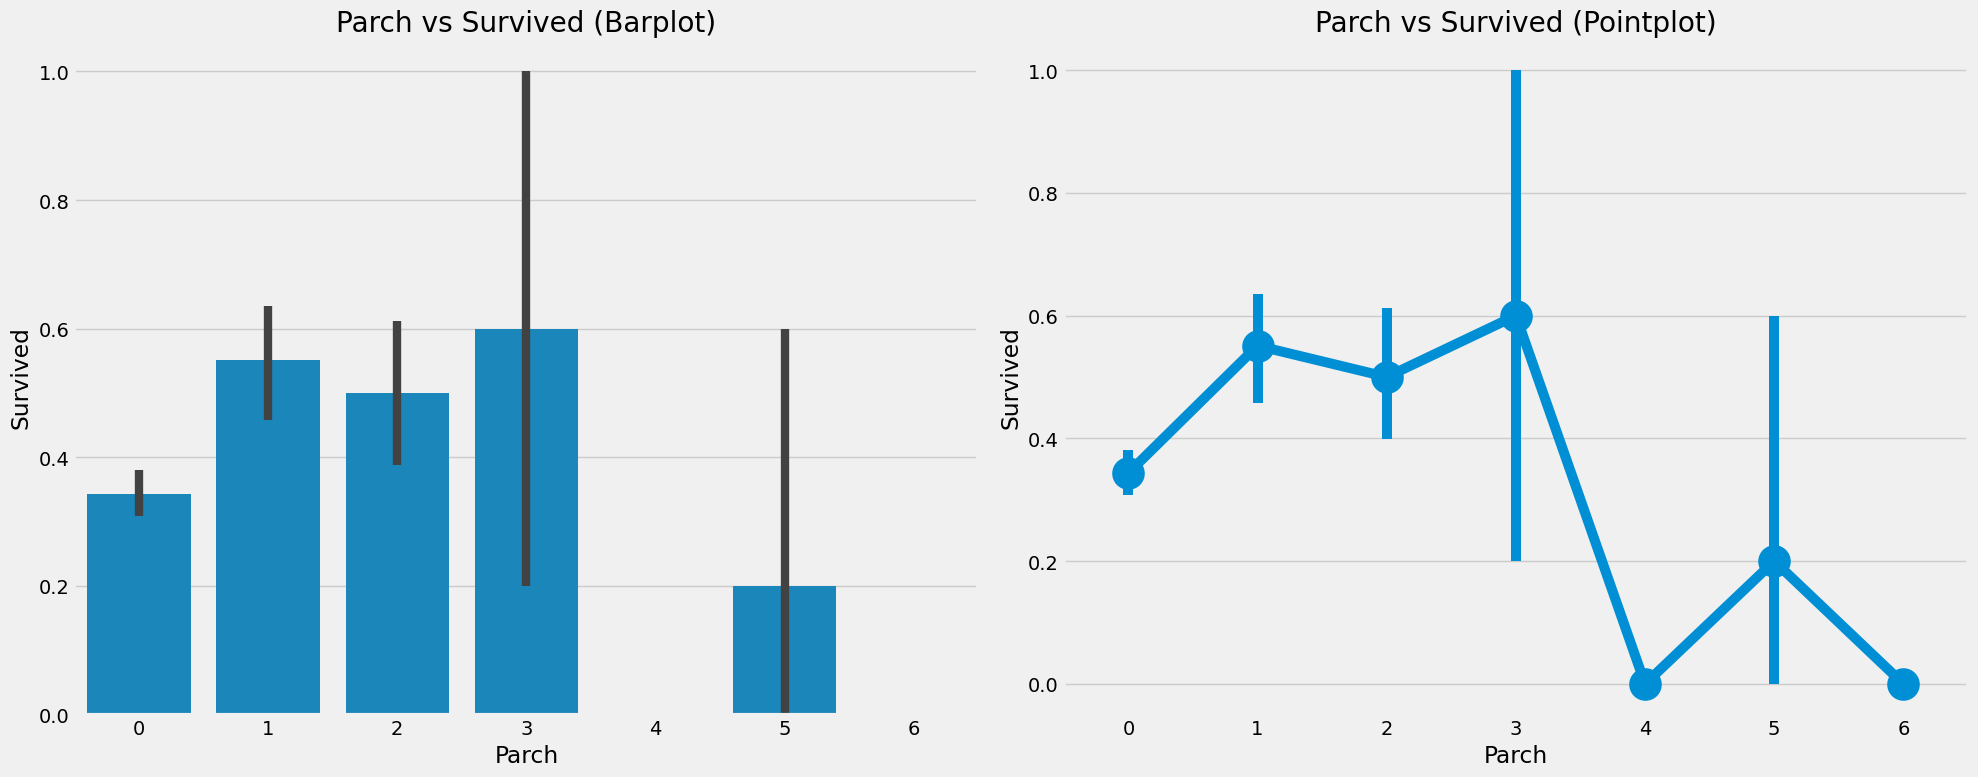

In [35]:
# Parch(부모/자녀 수)에 따라 생존률(Survived)이 어떻게 달라지는지 시각화하여 가족 유무와 생존 관계 분석

f, ax = plt.subplots(1, 2, figsize=(20, 8))

# (1) 막대그래프: Parch 수에 따른 평균 생존률
sns.barplot(x='Parch', y='Survived', data=train_df, ax=ax[0])
ax[0].set_title('Parch vs Survived (Barplot)')

# (2) 선형 포인트 그래프: 각 그룹의 생존률을 선과 점으로 표시
sns.pointplot(x='Parch', y='Survived', data=train_df, ax=ax[1])
ax[1].set_title('Parch vs Survived (Pointplot)')

plt.tight_layout()
plt.show()

### 관찰 결과 (Observations):
이 경우에도 유사한 경향이 나타났다.  
→ 부모나 자녀와 함께 탑승한 승객은 생존 확률이 더 높은 것으로 나타났다.

하지만 Parch(부모/자녀 수)가 많아질수록 그 생존률은 점차 감소하는 모습을 보인다.  

부모/자녀 수가 1~3명인 승객의 생존 확률은 높았지만,
혼자 탑승한 경우는 생존률이 낮고,
4명 이상의 부모/자녀가 함께 있을 경우 생존률이 급격히 감소한다.

<br>

여기서 중요한 인사이이트:

- Parch가 너무 적거나 너무 많은 경우 모두 생존률이 낮은 경향

- 적당한 가족 구성(1~3명)이 구조 우선순위에 도움이 되었을 가능성

## Fare--> Continous Feature

In [36]:
print('Highest Fare was:', train_df['Fare'].max())
print('Lowest Fare was:', train_df['Fare'].min())
print('Average Fare was:', train_df['Fare'].mean())

Highest Fare was: 512.3292
Lowest Fare was: 0.0
Average Fare was: 32.204207968574636


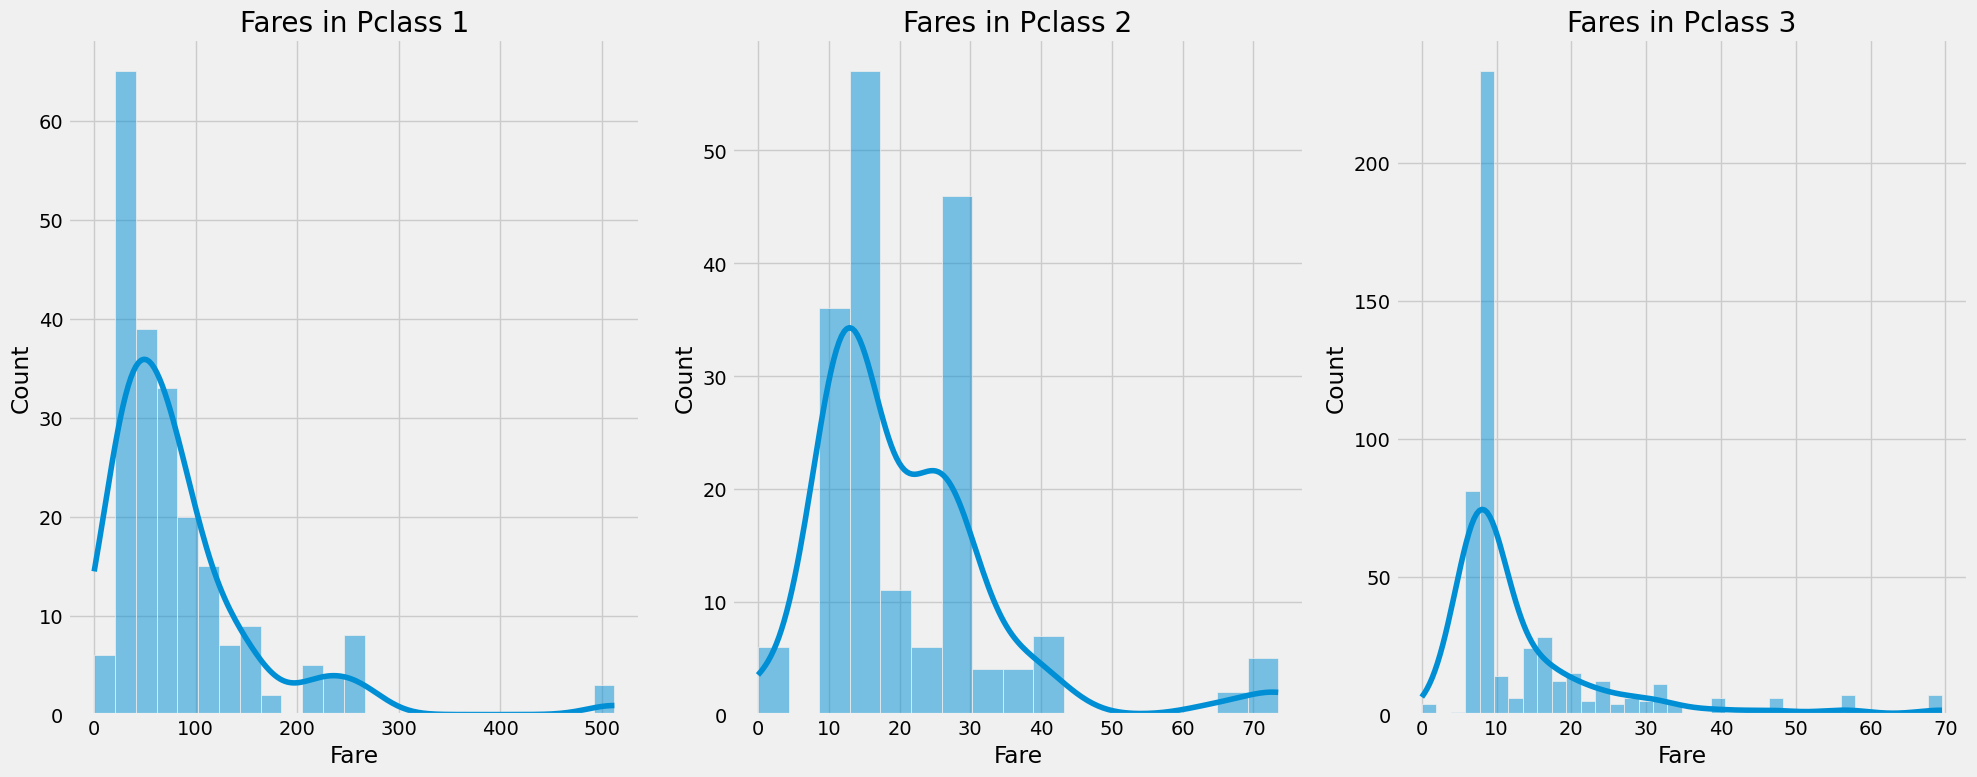

In [37]:
# 객실 등급(Pclass)에 따른 요금(Fare) 분포를 확인하여
# 요금과 등급의 관계 및 데이터의 분포 형태(왜도, 이상치 등)를 파악

f, ax = plt.subplots(1, 3, figsize=(20, 8))

# (1) Pclass 1 요금 분포
sns.histplot(train_df[train_df['Pclass'] == 1]['Fare'], kde=True, ax=ax[0])
ax[0].set_title('Fares in Pclass 1')

# (2) Pclass 2 요금 분포
sns.histplot(train_df[train_df['Pclass'] == 2]['Fare'], kde=True, ax=ax[1])
ax[1].set_title('Fares in Pclass 2')

# (3) Pclass 3 요금 분포
sns.histplot(train_df[train_df['Pclass'] == 3]['Fare'], kde=True, ax=ax[2])
ax[2].set_title('Fares in Pclass 3')

plt.tight_layout()
plt.show()


Pclass 1 승객들의 요금은 분포 범위가 매우 넓어 보이며, 등급이 낮아질수록 요금의 분포 폭도 줄어든다.  
요금(Fare)은 연속형 변수이기 때문에, 'binning(구간화)' 기법을 사용하여 이산형 변수로 변환할 수 있다.

<br>




## 모든 주요 Feature에 대한 핵심 요약 (Observations in a Nutshell)

Sex (성별)
- 여성의 생존 확률이 남성보다 확연히 높음

    → "여성과 아이 먼저(Women and Children First)" 원칙이 실제로 적용되었음을 보여줌

Pclass (객실 등급)
- 1등석 승객일수록 생존 확률이 높음

- 특히, 1등석 여성의 생존률은 거의 100%에 가까움

- 2등석 여성도 생존률이 높은 편

- 반면, 3등석 승객의 생존률은 매우 낮음

    → 돈이 생존 확률을 좌우했다, Money Wins?

Age (나이)
- 5~10세 이하 어린이 생존률이 매우 높음

- 반면, 15~35세 승객은 사망률이 높음

- 구조 시 어린이에 대한 우선 구조 원칙이 일부 적용된 듯

Embarked (탑승 항구)
- C(Cherbourg)에서 탑승한 승객의 생존률이 가장 높음
- S(Southampton)는 대부분의 1등석 승객이 탑승했지만 생존률은 낮음

- Q(Queenstown) 탑승객은 대부분 3등석 → 생존률 낮음

Parch + SibSp (가족 관계)
- 1-2명의 형제자매/배우자, 또는 1~-3명의 부모/자녀와 함께 탑승한 경우 생존률이 높음

- 혼자이거나, 대가족과 함께 탑승한 경우 생존률은 낮음

    → 가족 구성은 생존률에 긍정적이거나 부정적인 양면 효과를 줌

## Correlation Between The Features

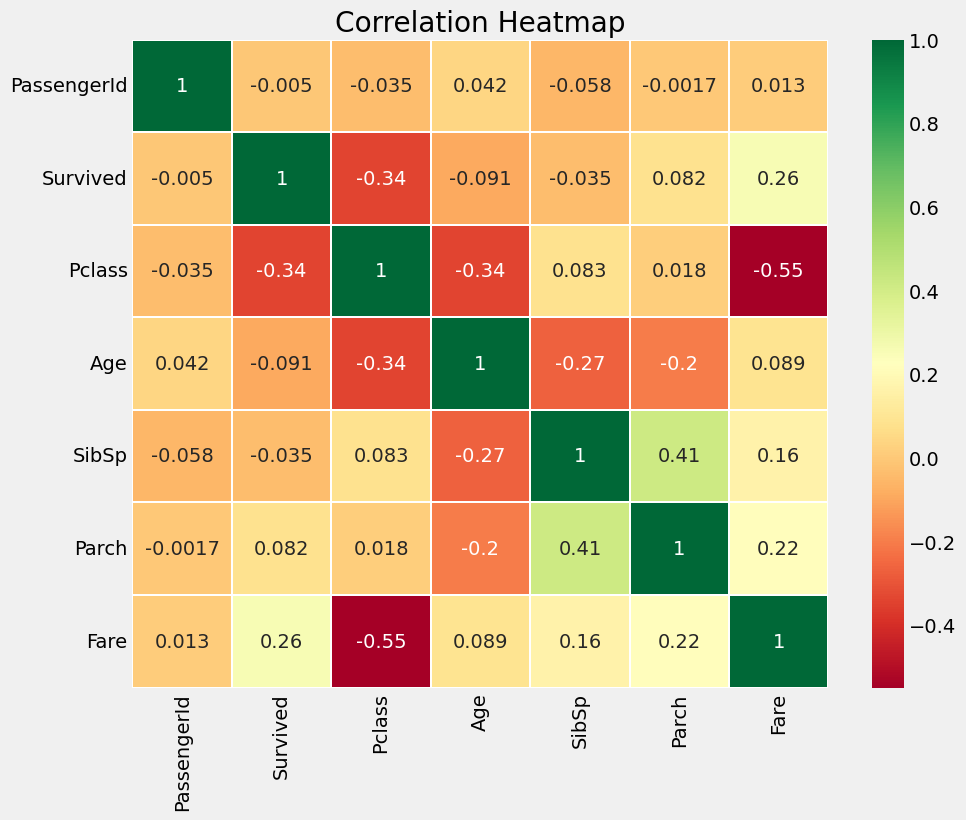

In [38]:
# 상관관계 분석: 수치형 피처 간의 상관관계를 시각화하여
# 서로 강한 상관성을 가지는 feature를 파악하고, 다중공선성이나 feature 선택에 활용할 수 있음

plt.figure(figsize=(10, 8))

# 상관관계 행렬 시각화 (각 변수 간의 Pearson 상관계수)
sns.heatmap(train_df.corr(numeric_only=True),  # 수치형 컬럼만 선택
            annot=True,
            cmap='RdYlGn',
            linewidths=0.2)

plt.title('Correlation Heatmap')
plt.show()


### 상관관계 히트맵 해석 (Interpreting the Heatmap)
우선 히트맵에서는 숫자형(numeric) 피처들만 비교된다는 점을 기억해야 한다.  
→ 문자열(string)이나 문자(alphabet)은 수치적으로 상관관계를 계산할 수 없기 때문

<br>

상관관계(Correlation)  
양의 상관관계 (Positive Correlation)  
→ 피처 A가 증가하면 피처 B도 함께 증가하는 경우  
→ 상관계수 값이 +1에 가까울수록 완벽한 양의 상관관계를 의미  

<br>

음의 상관관계 (Negative Correlation)
→ 피처 A가 증가하면 피처 B는 감소하는 경우  
→ 상관계수 값이 -1에 가까울수록 완벽한 음의 상관관계를 의미  

<br>

다중공선성(Multicollinearity)이란?  
만약 두 개의 피처가 매우 높은 상관관계를 가진다면,  
    → 이는 유사하거나 중복된 정보를 갖고 있다는 의미  
    → 즉, 둘 중 하나만 있어도 다른 하나의 값을 예측할 수 있기 때문에, 정보의 분산이 거의 없음을 의미

이를 다중공선성(Multicollinearity)이라고 부르며, 머신러닝 모델 학습 시 학습 시간 증가 및 해석 어려움 등 부작용이 있을 수 있다.

따라서 모델 학습 시에는 중복된 피처를 제거하는 것이 좋다.

<br>

인사이트:
- 전체적으로 피처들 간의 상관관계가 강하지는 않음

- 가장 높은 상관계수는 SibSp와 Parch 간의 0.41 → 가족 관련 변수 간의 상관성이 있음

- 나머지는 대부분 낮은 수치이므로, 현재는 모든 피처를 유지해도 괜찮음

# Part2: Feature Engineering and Data Cleaning

Feature Engineering이란?  

우리가 어떤 데이터셋을 제공받았을 때, 모든 피처(변수)가 유의미한 것은 아니다.

- 그중에는 모델 학습에 도움이 되지 않는 불필요하거나 중복된 피처도 있을 수 있으며,
이들은 제거 또는 변형이 필요하다.

- 반대로, 기존 피처에서 의미 있는 정보를 추출하거나 결합하여 새로운 피처를 만들 수도 있다.

예를 들어 이름(Name) 컬럼에서 Mr, Mrs, Miss 등의 호칭(Initials)을 추출하는 것도 피처 엔지니어링이라고 할 수 있다.

<br>

다음의 단계로 피처 엔지니어링을 수행하겠다.

1. 관찰을 통해 새로운 파생 피처 생성

2. 불필요한 피처 제거 또는 변환

3. 예측 모델링(Predictive Modeling)에 적합한 형태로 기존 피처 변형



## Age_band

Problem With Age Feature

앞서 언급했듯이 Age는 연속형(Continuous) 변수이인데, 머신러닝 모델에서는 연속형 변수는 다소 까다로울 수 있다.

예를 들어 만약 스포츠 선수를 성별(Sex)로 분류하라고 한다면, Male/Female과 같이 간단하게 명확한 그룹으로 나눌 수 있다.

그러나 나이(Age)로 분류하라고 하면 어떻게 될까? 30명의 사람이 있다면, 30개의 서로 다른 나이 값이 존재할 수 있다. 이렇게 값이 너무 다양하면 머신러닝 모델이 일반화하기 어려워진다.

<br>

연속형 데이터를 다음과 같은 방법으로 처리할 수 있다.

- Binning (구간화): 나이를 일정 범위로 나누어 카테고리화

- Normalization (정규화): 값의 범위를 0~1로 조정

이 중 Binning(구간화) 방식을 사용하여 나이 구간별로 그룹을 만들어 하나의 범주 값으로 묶도록 하겠다.

<br>

구간 나누기 기준은 어떻게 세우면 좋을까?

탑승객 중 최고령은 80세이고, 전체를 5개의 구간(bin)으로 나눌 것이다.

    각 구간의 크기는 80 / 5 = 16세 이므로

    0-16, 17-32, 33-48, 49-64, 65-80
이런 식으로 Age를 범주형 변수로 변환할 수 있다.

In [39]:
train_df['Age_band']=0
train_df.loc[train_df['Age']<=16, 'Age_band']=0
train_df.loc[(train_df['Age']>16)&(train_df['Age']<=32), 'Age_band']=1
train_df.loc[(train_df['Age']>32)&(train_df['Age']<=48), 'Age_band']=2
train_df.loc[(train_df['Age']>48)&(train_df['Age']<=64), 'Age_band']=3
train_df.loc[train_df['Age']>64, 'Age_band']=4
train_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Initial,Age_band
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,2


In [40]:
# Age 구간별로 몇 명의 탑승객이 속해 있는지 확인
train_df['Age_band'].value_counts().to_frame().style.background_gradient(cmap='summer')

,count
Age_band,
1,382
2,325
0,104
3,69
4,11


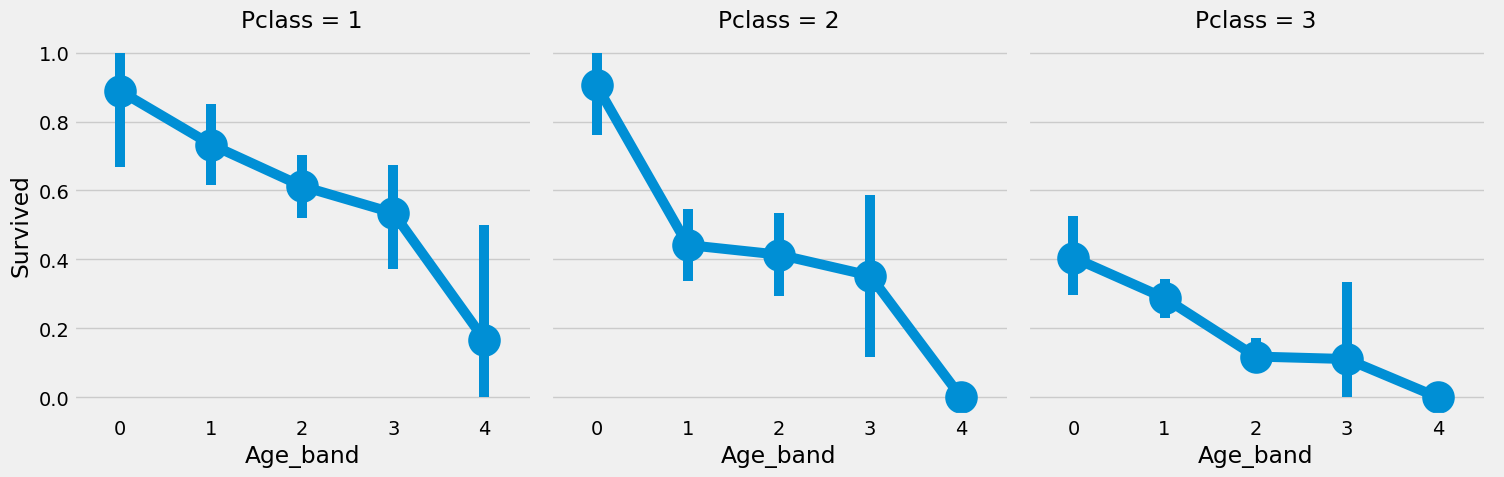

In [41]:
# 연령 구간(Age_band), 생존 여부(Survived), 객실 등급(Pclass)
# 각 Pclass 별 나이 구간에 따른 생존률 비교

sns.catplot(x='Age_band', y='Survived',
            data=train_df, col='Pclass', kind='point',
            height=5, aspect=1)

plt.tight_layout()
plt.show()

Pclass와 관계없이, 나이가 많아질수록 생존률은 전반적으로 감소하는 경향을 볼 수 있다.

특히 어린 아이(예: 0~10세)는 구조 우선 순위가 높았던 것으로 보이며, 중장년층(40대 이상)은 생존률이 급격히 떨어지는 모습이 관찰된다.

이는 Women and Children First" 정책과도 일치하는 부분이다.

## Family_Size and Alone

이번에는 Family_size와 Alone이라는 두 개의 새로운 파생 피처(feature)를 생성한다.

#### Family_size
- SibSp(형제자매 + 배우자 수)와 Parch(부모 + 자녀 수)를 합한 값
- 탑승한 가족 구성원의 총 수를 의미한다.

이 피처를 통해 가족이 많을수록 생존에 영향을 주는지를 분석할 수 있다.

#### Alone

- Family_size == 1일 경우 → 혼자 탑승

- 그렇지 않으면 → 가족과 함께 탑승

이 피처는 탑승객이 혼자였는지 여부를 구분하여, 혼자일 때 생존율이 낮은지 확인하는 데 사용될 수 있다.

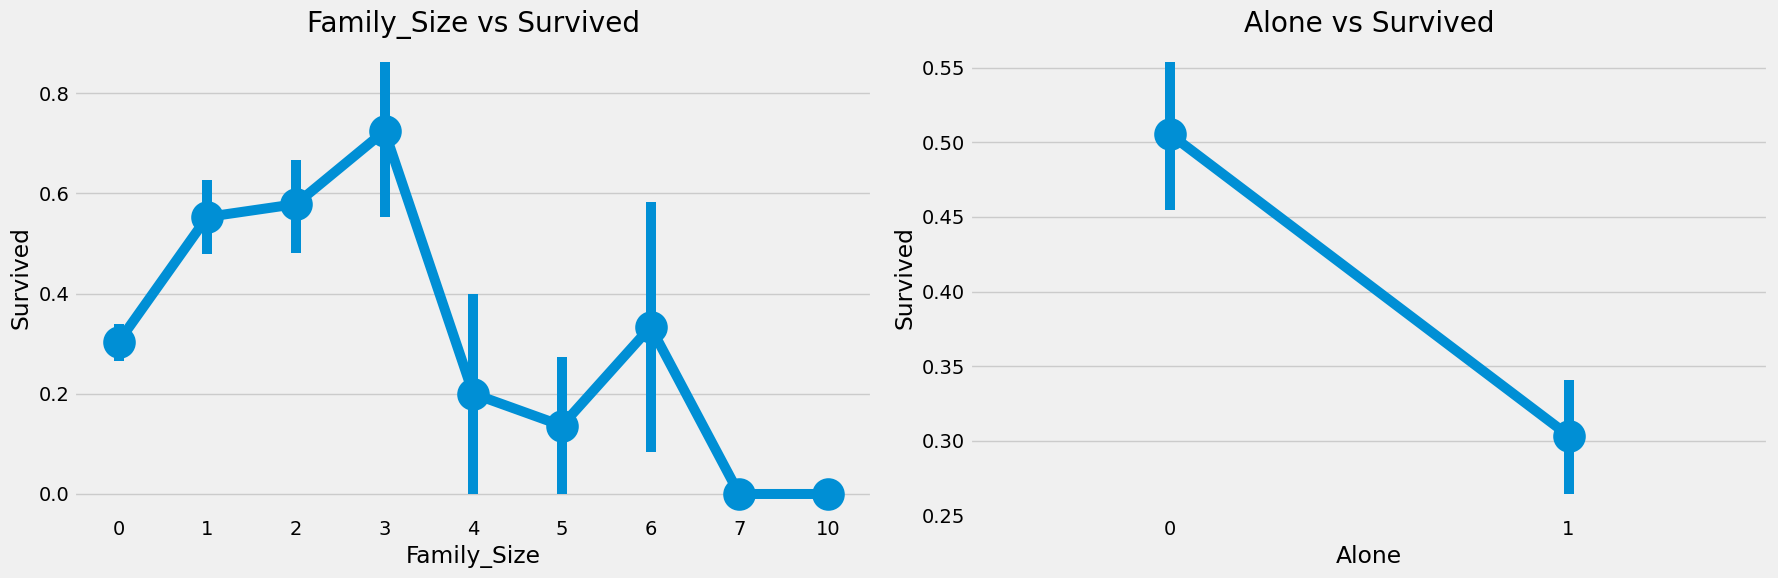

In [42]:
# 피처 생성
train_df['Family_Size'] = train_df['Parch'] + train_df['SibSp']
train_df['Alone'] = 0
train_df.loc[train_df['Family_Size'] == 0, 'Alone'] = 1

# Figure 및 Axes 직접 설정
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# (1) Family_Size에 따른 생존률
sns.pointplot(x='Family_Size', y='Survived', data=train_df, ax=ax[0])
ax[0].set_title('Family_Size vs Survived')

# (2) 혼자 여부(Alone)에 따른 생존률
sns.pointplot(x='Alone', y='Survived', data=train_df, ax=ax[1])
ax[1].set_title('Alone vs Survived')

plt.tight_layout()
plt.show()

Family_Size가 0이라는 것은 탑승객이 혼자라는 뜻이다. 혼자이거나 Family_Size가 0인 경우 생존 확률은 매우 낮다.

또한 Family_Size가 4를 초과하는 경우에도 생존 확률은 감소한다.

이 피처는 생존과 직접적인 상관관계를 갖는 피처로, 모델링에서 중요한 피처가 될 것으로 보인다.

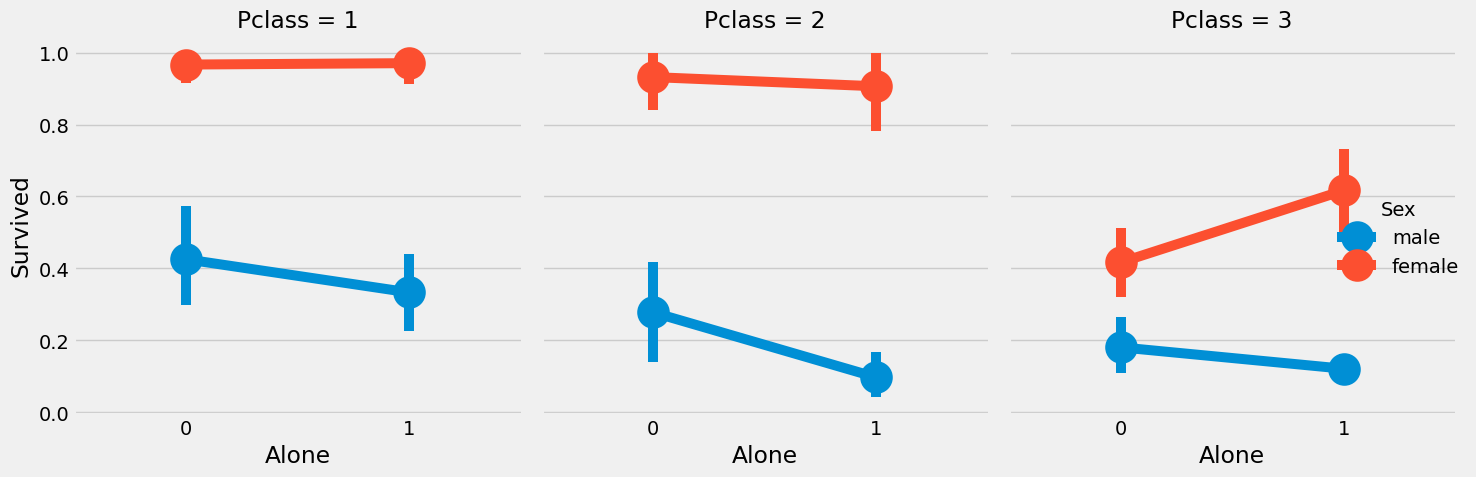

In [43]:
# Alone 여부와 성별, Pclass에 따른 생존률을 시각화
sns.catplot(
    x='Alone',              # x축: 혼자인지 여부 (0 = 가족 있음, 1 = 혼자)
    y='Survived',           # y축: 생존률
    hue='Sex',              # 색상 분리 기준: 성별
    col='Pclass',           # 각 Pclass별로 subplot 생성
    data=train_df,
    kind='point',
    height=5, aspect=0.9    # 각 subplot 크기 설정
)

plt.tight_layout()
plt.show()

성별(Sex)이나 선실 등급(Pclass)과 관계없이, 혼자인 경우 생존 확률이 낮은 경향이 뚜렷하게 보인다.  
단, 예외적으로 Pclass 3(3등석)에서는 혼자인 여성의 생존 확률이 가족과 함께 탑승한 여성보다 더 높다.

## Fare_Range

Fare(요금)는 연속형 특성이기 때문에, 이를 순서형 값으로 변환할 필요가 있다.
이를 위해 pandas.qcut()을 사용할 것이다.

qcut 함수는 지정한 **구간 수(bins)**에 따라 값을 동일한 개수로 나누어 구간을 생성한다.  
예를 들어 구간 수를 5로 설정하면, 전체 데이터를 5개의 동등한 분포를 가진 요금 구간으로 나누게 된다.

In [44]:
# 요금(Fare)의 연속형 데이터를 사분위 기반의 순서형 구간으로 나눈 후,
# 각 구간별 평균 생존률을 확인하여 요금과 생존 간의 관계 확인

# 연속형 Fare 데이터를 4개의 구간(사분위)으로 나눠 Fare_Range 컬럼 생성
train_df['Fare_Range'] = pd.qcut(train_df['Fare'], 4)

# Fare_Range별 생존률 평균을 계산
train_df.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r')

,Survived
Fare_Range,
"(-0.001, 7.91]",0.197309
"(7.91, 14.454]",0.303571
"(14.454, 31.0]",0.454955
"(31.0, 512.329]",0.581081


앞서 살펴본 것처럼, Fare_Range(요금 구간)가 높아질수록 생존 확률도 증가하는 경향이 뚜렷하게 나타난다.

Fare_Range 값을 범위 문자열 형태로는 모델에 전달할 수 없다.  
따라서 Age_Band에서 했던 것처럼 단일한 숫자 값으로 변환해야 한다.



In [45]:
# Fare_Range를 모델 학습에 적합하도록 정수형 범주(Fare_cat)로 변환

train_df['Fare_cat'] = 0

# 가장 저렴한 요금 구간 (0 ~ 7.91) → 카테고리 0
train_df.loc[train_df['Fare'] <= 7.91, 'Fare_cat'] = 0

# 7.91 초과 ~ 14.454 이하 구간 → 카테고리 1
train_df.loc[(train_df['Fare'] > 7.91) & (train_df['Fare'] <= 14.454), 'Fare_cat'] = 1

# 14.454 초과 ~ 31 이하 구간 → 카테고리 2
train_df.loc[(train_df['Fare'] > 14.454) & (train_df['Fare'] <= 31), 'Fare_cat'] = 2

# 31 초과 ~ 513 이하 (가장 비싼 요금 구간) → 카테고리 3
train_df.loc[(train_df['Fare'] > 31) & (train_df['Fare'] <= 513), 'Fare_cat'] = 3

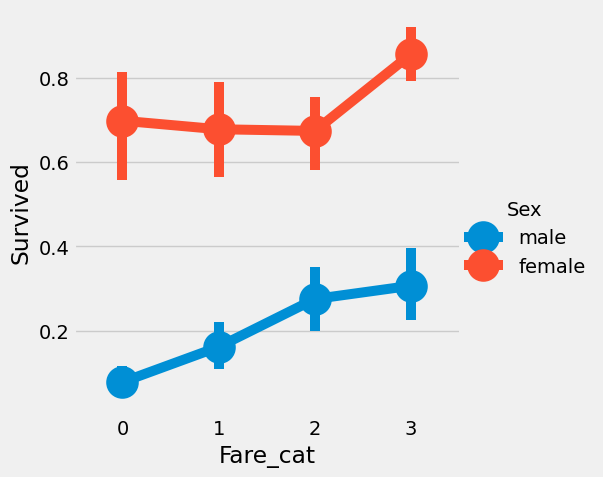

In [46]:
# 요금 범주와 생존 여부의 관계를 성별(Sex) 기준으로 나누어 비교

sns.catplot(
    x='Fare_cat',             # x축: 요금 범주
    y='Survived',             # y축: 생존률
    hue='Sex',                # 색상 구분: 성별
    data=train_df,
    kind='point',
    height=5, aspect=1
)

plt.show()

명확하게 보이듯이, Fare_cat(요금 범주)가 높아질수록 생존 확률도 증가하는 경향이 명확하게 보인다.

이 피처는 Sex(성별)과 함께 모델링 시에 중요한 피처가 될 수 있다.



## Converting String Values into Numeric

머신러닝 모델은 문자열(String)을 직접 처리하지 못하기 때문에  
Sex, Embarked와 같은 범주형 문자열 컬럼들을 숫자형 값으로 변환하는 인코딩을 해야 한다.

In [47]:
# 성별(Sex): male → 0, female → 1
train_df['Sex'].replace(['male', 'female'], [0, 1], inplace=True)

# 탑승 항구(Embarked): S → 0, C → 1, Q → 2
train_df['Embarked'].replace(['S', 'C', 'Q'], [0, 1, 2], inplace=True)

# 탑승객 호칭(Initial): Mr → 0, Mrs → 1, Miss → 2, Master → 3, Other → 4
train_df['Initial'].replace(['Mr', 'Mrs', 'Miss', 'Master', 'Other'], [0, 1, 2, 3, 4], inplace=True)

### Dropping UnNeeded Features

Name → 범주형으로 변환이 불가능하므로 제거

Age → Age_band를 생성했기 때문에 불필요하므로 제거

Ticket → 의미 없는 임의의 문자열이기 때문에 제거

Fare → Fare_cat을 생성했기 때문에 제거

Cabin → 결측치 및 중복 정보가 많으므로 제거

Fare_Range → Fare_cat으로 변환되었기 때문에 제거

PassengerId → 고유 식별자로서 범주화 불가능하며 모델 학습에 의미가 없기 때문에 제거



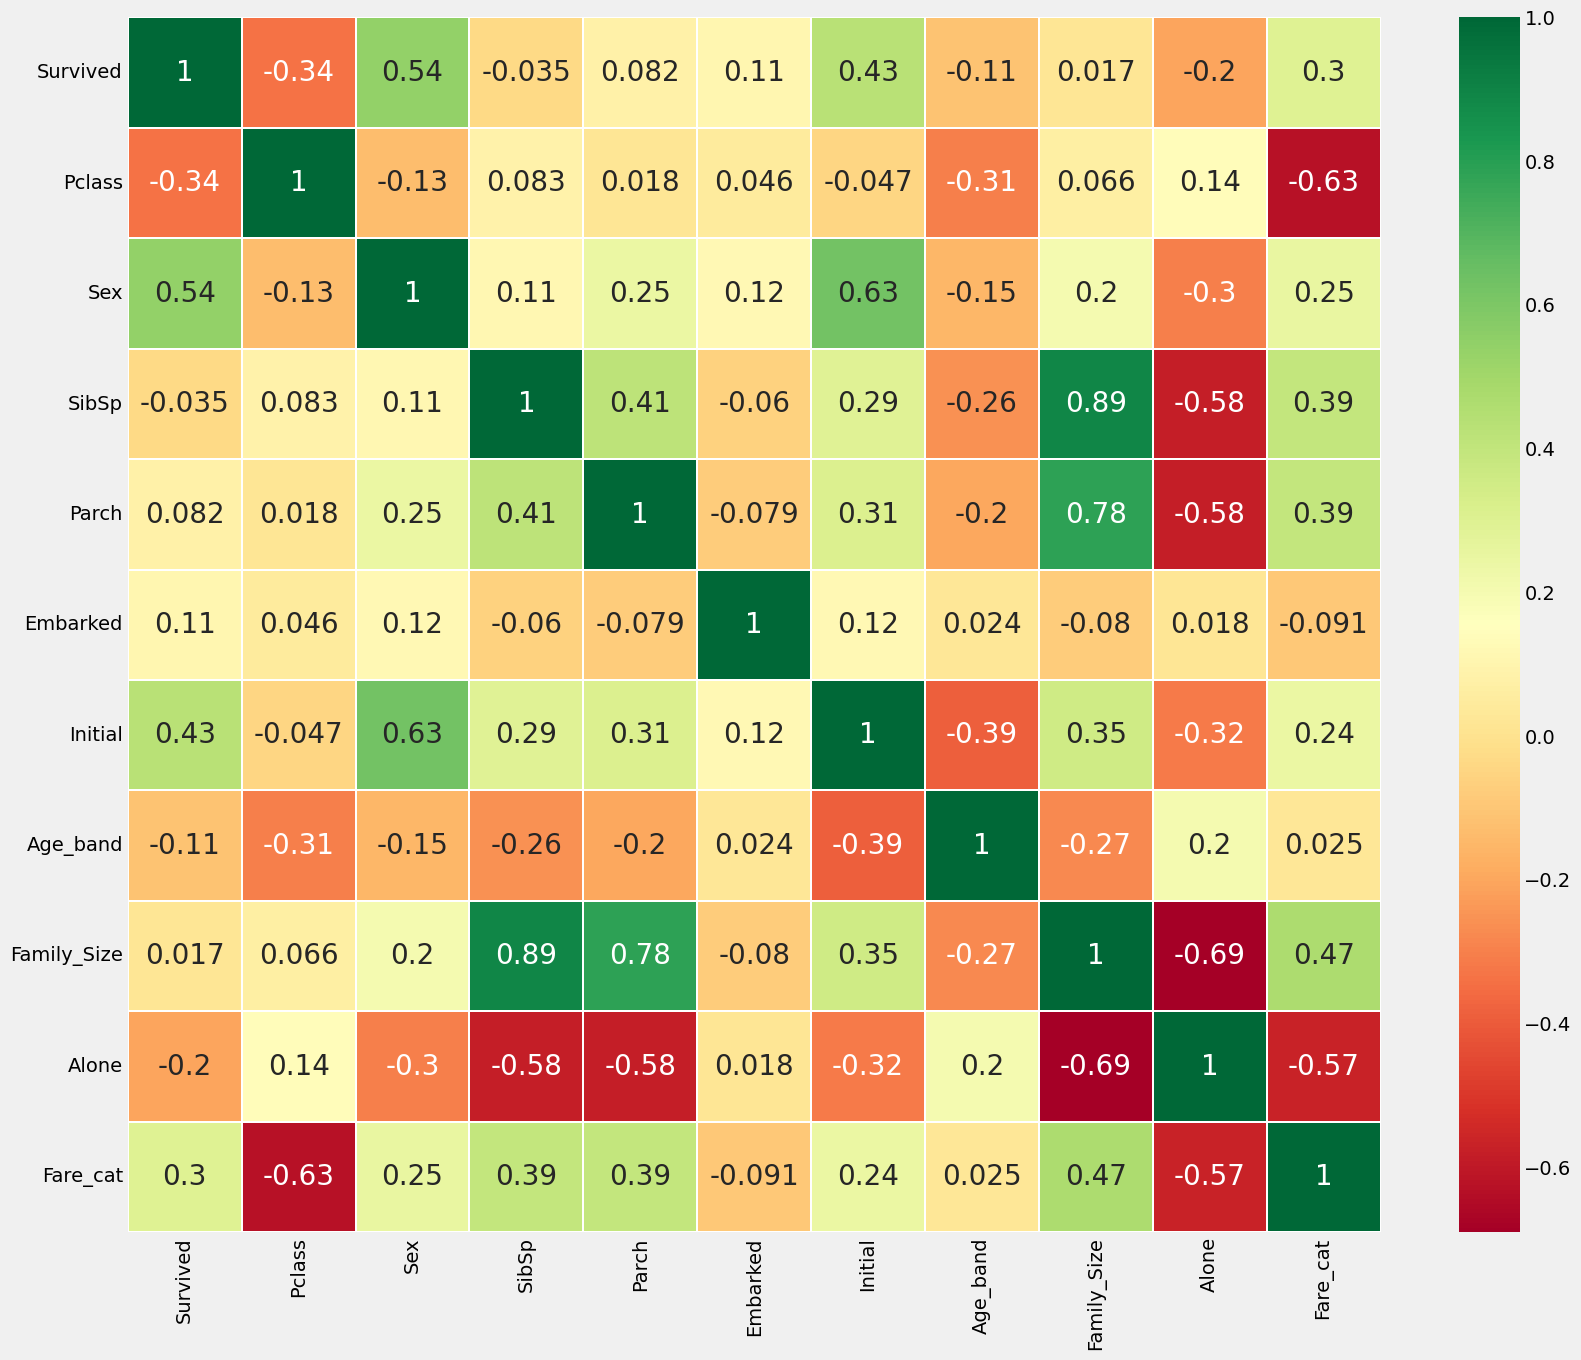

In [48]:
# 모델링에 불필요한 컬럼들을 제거하고, 남은 수치형 피처들의 상관관계 시각화

# 불필요하거나 중복되었거나 수치화가 어려운 컬럼 삭제
train_df.drop(['Name', 'Age', 'Ticket', 'Fare', 'Cabin', 'Fare_Range', 'PassengerId'], axis=1, inplace=True)

# 컬럼 간의 상관관계 시각화
sns.heatmap(
    train_df.corr(),          # 상관관계 행렬
    annot=True,               # 각 셀에 수치 표시
    cmap='RdYlGn',            # 색상 팔레트 (빨강-노랑-초록)
    linewidths=0.2,           # 셀 경계선 두께
    annot_kws={'size': 20}    # 수치 텍스트 크기
)

fig = plt.gcf()
fig.set_size_inches(18, 15)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

이제 몇 가지 상관관계 특성을 확인할 수 있다.

양의 상관관계가 있는 것은 SibSp와 Family_Size, Parch와 Family_Size 간의 관계이며,   
반대로 음의 상관관계를 가지는 것으로는 Alone과 Family_Size가 있다.

# Part3: Predictive Modeling

EDA(탐색적 데이터 분석) 단계에서 몇 가지 인사이트를 얻었다. 하지만 그것만으로는 승객이 생존했는지 사망했는지를 정확하게 예측할 수 없다.

이제 분류(Classification) 알고리즘들을 사용하여 승객의 생존 여부를 예측해 볼 것이다.

<br>

모델을 만들기 위해 사용할 알고리즘들은 다음과 같다.

1. 서포트 벡터 머신 (Support Vector Machines - 선형 및 방사형 커널)
2. 랜덤 포레스트 (Random Forest)
3. K-최근접 이웃 (K-Nearest Neighbours)
4. 나이브 베이즈 (Naive Bayes)
5. 결정 트리 (Decision Tree)
6. 로지스틱 회귀 (Logistic Regression)


EDA에서 발견한 패턴(성별, 나이, 객실 등급 등)이 실제 예측에 얼마나 도움이 되는지 확인해볼 수 있다.  
또한, 다양한 알고리즘을 비교해 보면서 가장 성능이 좋은 모델을 선택해 보자.

In [49]:
from sklearn.linear_model import LogisticRegression     # 로지스틱 회귀
from sklearn import svm                                 # 서포트 벡터 머신
from sklearn.ensemble import RandomForestClassifier     # 랜덤 포레스트
from sklearn.neighbors import KNeighborsClassifier      # K-최근접 이웃
from sklearn.naive_bayes import GaussianNB              # 나이브 베이즈 (가우시안)
from sklearn.tree import DecisionTreeClassifier         # 결정 트리

from sklearn.model_selection import train_test_split    # 학습/테스트 데이터 분할
from sklearn import metrics                             # 정확도 등 평가 지표
from sklearn.metrics import confusion_matrix            # 혼동 행렬


In [50]:
# 전체 데이터(train_df)를 학습 데이터(train)와 테스트 데이터(test)로 분할

# stratify를 통해 Survived의 비율을 유지하며 분할
train, test = train_test_split(train_df, test_size=0.3, random_state=0, stratify=train_df['Survived'])

# 학습 데이터에서 입력값(X)과 정답값(Y) 분리
train_X = train[train.columns[1:]]    # 첫 번째 열(Survived)을 제외한 나머지 = feature
train_Y = train[train.columns[:1]]    # 첫 번째 열(Survived)만 선택 = label

# 테스트 데이터에서 입력값(X)과 정답값(Y) 분리
test_X = test[test.columns[1:]]       # feature
test_Y = test[test.columns[:1]]       # label

# 전체 데이터셋의 특성과 타겟도 따로 저장 (모델 전체 학습 시 사용 가능)
X = train_df[train_df.columns[1:]]    # feature 전체
Y = train_df['Survived']              # label 전체

### 1. Supprot Vector Machines(SVM)

SVM(Support Vector Machine):   
데이터를 분리하는 최적의 결정 경계(Decision Boundary)를 찾는 지도 학습 분류 알고리즘

### 1.1. Radial Support Vector Machines(RBF-SVM)

Support Vector Machine(SVM)의 비선형 커널 중 하나로,  
데이터가 선형으로 분리되지 않을 때(곡선 기준 분류) 사용된다.

RBF(Radial Basis Function) 커널:  
데이터를 고차원으로 매핑하여, 선형적으로 분리되지 않는 데이터도 분류 가능하게 만들어 줌

In [51]:
# RBF-SVM 모델을 학습하고 예측 정확도 평가

# rbf 커널을 사용하는 SVM 모델 정의
# C: 오차 허용도 (높을수록 과적합 위험), gamma: 데이터 포인트의 영향력 범위
model = svm.SVC(kernel='rbf', C=1, gamma=0.1)

# 모델 학습
model.fit(train_X, train_Y)

# 테스트 데이터로 생존 여부 예측
prediction1 = model.predict(test_X)

# 예측 결과 정확도 출력
print('Accuracy for rbf SVM is ', metrics.accuracy_score(prediction1, test_Y))


Accuracy for rbf SVM is  0.835820895522388


### 1.2 Linear Support Vector Machine (Linear-SVM)

입력 특성들이 선형적으로 구분될 수 있다고 가정하고, 직선 또는 초평면(Hyperplane)을 기준으로 분류

- 특성 간의 관계가 선형적인 분포일 때 (ex. 직선으로 구분 가능할 때)
- 고차원 희소 데이터(예: 텍스트 분류)에 강함





In [52]:
# Linear-SVM 모델을 학습하고 예측 정확도 평가

# linear 커널을 사용하는 SVM 모델 정의
# C: 오차 허용도 (작을수록 규제가 강해짐 → 단순한 모델 유도)
# gamma: linear 커널에서는 사용되지 않지만, 명시해도 무시됨
model = svm.SVC(kernel='linear', C=0.1, gamma=0.1)

# 모델 학습
model.fit(train_X, train_Y)

# 테스트 데이터로 생존 여부 예측
prediction2 = model.predict(test_X)

# 예측 결과 정확도 출력
print('Accuracy for linear SVM is', metrics.accuracy_score(prediction2, test_Y))


Accuracy for linear SVM is 0.8171641791044776


### 2. Logistic Regression

이진 분류(binary classification) 문제에 자주 사용되는 선형 모델로,  
입력값을 선형 조합하여 시그모이드 함수(0~1)로 출력값을 변환한다.

특정 사건이 발생할 확률을 예측하는데, 생존 여부는 0 또는 1의 이진 분류 문제이므로 Logistic Regression이 적합하다.

In [53]:
# Logistic Regression 모델을 학습하고 예측 정확도 평가

# Logistic Regression 모델 생성
model = LogisticRegression()

# 모델 학습
model.fit(train_X, train_Y)

# 테스트 데이터로 생존 여부 예측
prediction3 = model.predict(test_X)

# 예측 결과 정확도 출력
print('The accuracy of the Logistic Regression is', metrics.accuracy_score(prediction3, test_Y))

The accuracy of the Logistic Regression is 0.8134328358208955


### 3. Decision Tree

데이터를 분할(split)하며 조건에 따라 의사결정을 수행하는 트리 형태의 모델이다.
- 각 노드: 특정 피처의 조건
- 리프 노드: 예측 클래스

사람이 해석하기 쉬운 모델로, 설명 가능성(Explainability)이 높지만, 과적합(overfitting)에 주의가 필요하다.



In [54]:
# Decision Tree 모델을 학습하고 예측 정확도 평가

# Decision Tree 모델 생성
model = DecisionTreeClassifier()

# 모델 학습
model.fit(train_X, train_Y)

# 테스트 데이터로 생존 여부 예측
prediction4 = model.predict(test_X)

# 예측 결과 정확도 출력
print('The accuracy of the Decision Tree is', metrics.accuracy_score(prediction4, test_Y))

The accuracy of the Decision Tree is 0.8059701492537313


### 4. K-Nearest Neighbours(KNN)

훈련 데이터를 기준으로 가장 가까운 K개의 이웃을 찾아 예측을 수행한다. 예측 시 거리 기반 다수결 투표로 클래스 결정한다.



성별, 나이, 등급(Pclass), 요금(Fare) 등 수치 기반의 피처 간 유사성을 활용하기에 적합하다.

- 학습은 빠르지만, 예측 시 시간이 오래 걸릴 수 있음 (비모수적, 저장 기반 모델)
- 다만 스케일링(StandardScaler 등)이 되어 있어야 좋은 성능을 기대할 수 있음

In [55]:
# Decision Tree 모델을 학습하고 예측 정확도 평가

# KNN 모델 생성 (k=9로 설정)
model = KNeighborsClassifier(n_neighbors=9)

# 모델 학습
model.fit(train_X, train_Y)

# 테스트 데이터로 생존 여부 예측
prediction5 = model.predict(test_X)

# 예측 결과 정확도 출력
print('The accuracy of the KNN is', metrics.accuracy_score(prediction5, test_Y))

The accuracy of the KNN is 0.8470149253731343


이제 KNN 모델의 정확도는 n_neighbors 속성의 값을 바꿈에 따라 달라진다.  
기본값은 5이며, 여러 n_neighbors 값에 따른 정확도를 확인해 보자.

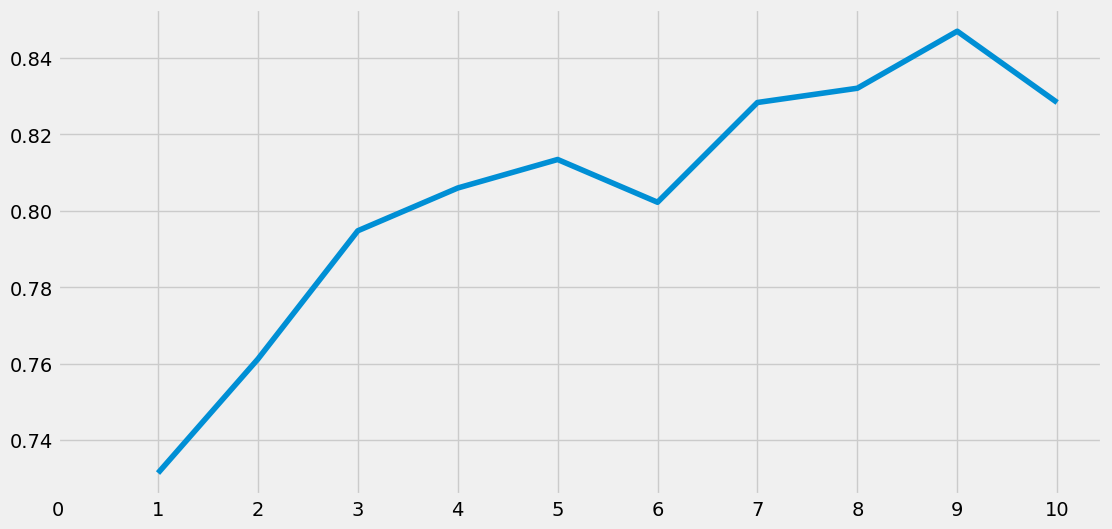

Accuracies for different values of n are: [0.73134328 0.76119403 0.79477612 0.80597015 0.81343284 0.80223881
 0.82835821 0.83208955 0.84701493 0.82835821] with the max value as  0.8470149253731343


In [56]:
# k 값에 따른 KNN(K-Nearest Neighbors) 모델의 성능(정확도) 비교

a_index = list(range(1, 11))             # x축에 사용할 n_neighbors 값
a_list = []                              # pandas 1.4.0 이상에는 .append() 메서드를 Series에 사용 불가
x = list(range(0, 11))                   # x축 눈금

# k 값을 1~10까지 바꿔가며 모델 학습 및 예측
for i in a_index:
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(train_X, train_Y)
    prediction = model.predict(test_X)
    a_list.append(metrics.accuracy_score(prediction, test_Y))

# 리스트 → 시리즈 변환
a = pd.Series(a_list)

# 정확도 시각화
plt.plot(a_index, a)
plt.xticks(x)
fig = plt.gcf()
fig.set_size_inches(12, 6)
plt.show()

# 가장 높은 정확도 출력
print('Accuracies for different values of n are:', a.values, 'with the max value as ', a.values.max())

### 5. Gaussian Naive Bayes

연속형 피처를 가진 데이터에 적합한 확률 기반 분류 알고리즘이다. 각 클래스에 대해 특징(feature)의 분포가 **가우시안(정규 분포)**을 따른다고 가정하고, 베이즈 정리를 통해 분류를 수행한다.

- 빠르게 baseline 모델 성능을 비교하거나 속도가 중요한 경우 매우 유용
- 피처 간 독립 가정 때문에 실제 분포와 맞지 않으면 성능이 낮을 수 있음

- Titanic 데이터셋처럼 일부 피처 간 상관관계가 존재할 수 있는 경우, Naive Bayes 성능은 다른 모델보다 낮을 수 있음

<br>

Naive Bayes 알고리즘 중에서도 연속형 데이터를 처리할 수 있는 GaussianNB를 사용한다.  
Titanic 데이터의 수치형 피처(Age, Fare 등)에 잘 맞는 형태이지만, 피처 간 독립을 가정하기 때문에 복잡한 상관관계가 많은 경우 성능이 떨어질 수 있다.


In [57]:
# Gaussian Naive Bayes 모델을 학습하고 예측 정확도 평가

# Gaussian Naive Bayes 모델 생성
model = GaussianNB()

# 모델 학습
#     train_X : 입력 피처, train_Y : 정답 (Survived)
model.fit(train_X, train_Y)

# 테스트 데이터로 생존 여부 예측
prediction6 = model.predict(test_X)

# 예측 결과 정확도 출력
print('The accuracy of the NaiveBayes is', metrics.accuracy_score(prediction6, test_Y))

The accuracy of the NaiveBayes is 0.8134328358208955


### 6. Random Forest

여러 개의 Decision Tree를 조합해 예측을 수행하는 앙상블 학습 알고리즘이다.  
각각의 트리는 데이터 샘플 일부 및 피처 일부만 사용하여 독립적으로 학습한다.

- 과적합 방지, 안정적인 성능, 변수 중요도 확인 가능
- 개별 트리보다 느림, 해석 어려움

데이터 샘플을 무작위로 선택하고 피처도 무작위로 일부만 사용는데  
이를 통해 트리들이 서로 다른 시각에서 문제를 바라보게 되고 다양한 예측 결과를 조합하면서 더 일반화된 예측이 가능해진다.



In [58]:
# Random Forest 모델을 학습하고 예측 정확도 평가

# Random Forest 모델 생성 (트리 100개 사용)
model = RandomForestClassifier(n_estimators=100)

# 모델 학습
model.fit(train_X, train_Y)

# 테스트 데이터로 생존 여부 예측
prediction7 = model.predict(test_X)

# 예측 결과 정확도 출력
print('The accuracy of the Random Forests is', metrics.accuracy_score(prediction7, test_Y))

The accuracy of the Random Forests is 0.8171641791044776


모델의 정확도(Accuracy)는 분류기의 강건성(Robustness)을 판단하는 유일한 기준은 아니다.

예를 들어, 어떤 분류기가 훈련 데이터로 학습되고 테스트 데이터로 테스트되어 90%의 정확도를 보였다고 가정해 보자.

이 정확도는 꽤 좋아 보이지만, 새로운 테스트 세트에서도 항상 90%의 정확도를 보일 수 있을까?

그렇지 않다.  
왜냐하면 어떤 데이터 인스턴스를 훈련에 사용할지에 따라 결과가 달라질 수 있기 때문이다.  
즉, 훈련 데이터와 테스트 데이터가 달라지면 정확도 역시 증가하거나 감소할 수 있습니다.

이러한 특성을 모델 분산(Model Variance)이라고 한다.

<br>

이 문제를 해결하고 일반화된 모델을 만들기 위해 교차 검증(Cross Validation)을 사용할 것이다.

## Cross Validation

종종 데이터는 불균형(imbalanced) 상태일 수 있다.  
예를 들어 한 클래스(class1)의 인스턴스는 많지만, 다른 클래스 인스턴스는 적을 수 있다.  
따라서 알고리즘을 데이터셋의 모든 인스턴스에 대해 학습하고 테스트해야 한다.  
그런 다음, 기록된 모든 정확도의 평균을 계산할 수 있다.

<br>

**K-Fold 교차 검증(K-Fold Cross Validation)**은 데이터셋을 K개의 하위 집합(k-subsets)으로 나누는 방식입니다.

예를 들어 K=5로 나눈다고 가정하면, 그 중 1개를 테스트용으로 남겨두고 나머지 4개로 모델을 학습한다.

이 과정을 반복하면서 매번 다른 파트를 테스트셋으로 설정하고, 나머지를 훈련셋으로 사용한다.
이렇게 해서 모든 파트가 한 번씩 테스트셋이 되도록 반복한다.
각각의 정확도와 오차를 기록한 후, 전체 평균을 계산하여 알고리즘의 평균 정확도를 얻는다.

<br>

어떤 알고리즘은 일부 데이터셋에서는 과소적합(Underfit)하고, 다른 데이터셋에서는 과적합(Overfit)할 수 있다.  
교차 검증을 통해 일반화된(generalised) 모델을 얻을 수 있게 된다.

In [59]:
# K-Fold 교차 검증 및 다양한 모델 성능 비교

from sklearn.model_selection import KFold              # K-Fold 교차 검증을 위한 클래스
from sklearn.model_selection import cross_val_score    # 모델의 정확도를 평가하기 위한 함수
from sklearn.model_selection import cross_val_predict  # 교차 검증에 기반한 예측 생성

kfold = KFold(n_splits=10, random_state=22, shuffle=True)  # 데이터를 10개로 나누는 K-Fold 객체 생성

xyz = []        # 각 모델의 평균 정확도 저장 리스트
accuracy = []   # 각 모델의 전체 교차검증 정확도 리스트
std = []        # 각 모델의 정확도 표준편차 저장 리스트

# 평가할 분류기 이름과 해당 모델 객체 정의
classifiers = ['Linear SVM', 'Radial SVM', 'Logistic Regression', 'KNN', 'Decision Tree', 'Naive Bayes', 'Random Forest']
models = [
    svm.SVC(kernel='linear'),                  # 선형 SVM
    svm.SVC(kernel='rbf'),                     # RBF 커널 SVM
    LogisticRegression(),                      # 로지스틱 회귀
    KNeighborsClassifier(n_neighbors=9),       # K-최근접 이웃 (K=9)
    DecisionTreeClassifier(),                  # 결정 트리
    GaussianNB(),                              # 가우시안 나이브 베이즈
    RandomForestClassifier(n_estimators=100)   # 랜덤 포레스트 (트리 100개)
]

# 각 모델에 대해 교차 검증 수행
for i in models:
    model = i
    cv_result = cross_val_score(model, X, Y, cv=kfold, scoring="accuracy")  # 각 모델의 교차 검증 정확도 점수
    xyz.append(cv_result.mean())      # 평균 정확도 저장
    std.append(cv_result.std())       # 표준편차 저장
    accuracy.append(cv_result)        # 전체 정확도 배열 저장

# 결과를 정리한 데이터프레임 생성
new_models_dataframe2 = pd.DataFrame({'CV Mean': xyz, 'Std': std}, index=classifiers)

# 교차 검증 결과 출력
new_models_dataframe2

,CV Mean,Std
Linear SVM,0.784607,0.057841
Radial SVM,0.828377,0.057096
Logistic Regression,0.799176,0.040154
KNN,0.808140,0.035630
Decision Tree,0.806979,0.045900
Naive Bayes,0.795843,0.054861
Random Forest,0.808140,0.043015


<Axes: >

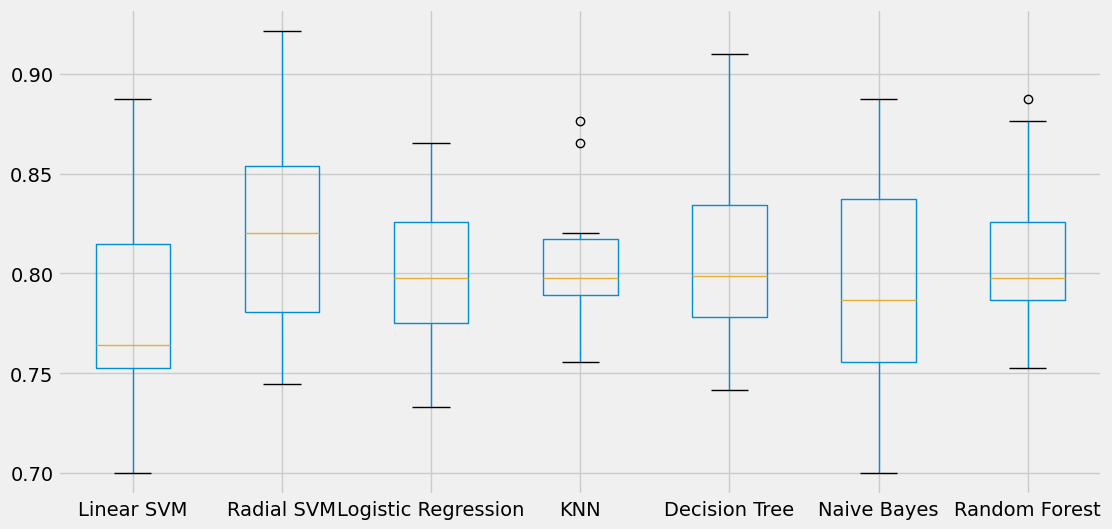

In [60]:
# 각 모델의 교차 검증 정확도 분포 시각화

plt.subplots(figsize=(12, 6))

# accuracy 리스트에는 각 모델의 10회 교차 검증 결과(정확도 리스트)가 들어 있음
# 이를 DataFrame으로 변환하여 모델명을 index로 설정
box = pd.DataFrame(accuracy, index=classifiers)

# 전치(T)를 통해 각 모델이 열(column)이 되도록 변환 → 박스플롯을 그릴 수 있도록 구성
box.T.boxplot()

여러 모델의 정확도 분포(variance)를 비교하여, 어떤 모델이 성능의 일관성이 높은지 파악할 수 있었다.

이처럼 Boxplot은 평균, 사분위수, 이상치 등을 한눈에 확인할 수 있어서 모델 평가에 유용하다.

<br>

이제 7가지 모델의 평균 정확도(CV Mean)를 한눈에 비교할 수 있도록 수평 막대 그래프로 시각화해 보자.  
가장 높은 평균 정확도를 보이는 모델을 쉽게 파악할 수 있다.

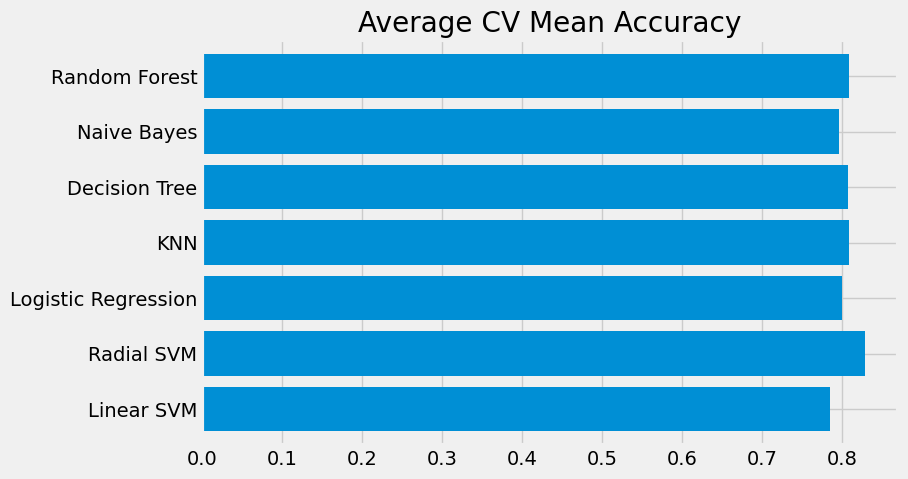

In [61]:
# 모델별 평균 교차 검증 정확도 시각화

# 각 모델의 평균 정확도 값을 수평 막대(barh)로 그림
new_models_dataframe2['CV Mean'].plot.barh(width=0.8)

plt.title('Average CV Mean Accuracy')

fig = plt.gcf()
fig.set_size_inches(8, 5)

plt.show()

분류 정확도는 클래스 불균형(imbalance) 때문에 가끔 오해를 불러일으킬 수 있다.

따라서 confusion matrix를 사용하여 보다 요약된 결과를 얻을 것이다. 이 행렬은 모델이 어디서 틀렸는지, 어떤 클래스를 잘못 예측했는지를 보여준다.



## Confusion Matrix

Confusion Matrix는 분류기가 만든 올바른 분류와 잘못된 분류의 개수를 보여준다.

모델이 정확하게 맞춘 경우와 틀린 경우를 구체적으로 숫자로 보여주기 때문에, 예측 결과의 세부적인 성능을 평가할 때 사용한다.


- `cross_val_predict()`  
    교차 검증 기반의 예측값을 얻을 수 있어 더 일반화된 confusion matrix를 볼 수 있음
- `confusion_matrix(Y, y_pred)`  
    실제 값 Y와 예측값 y_pred를 비교하여 True/False Positive, Negative를 계산




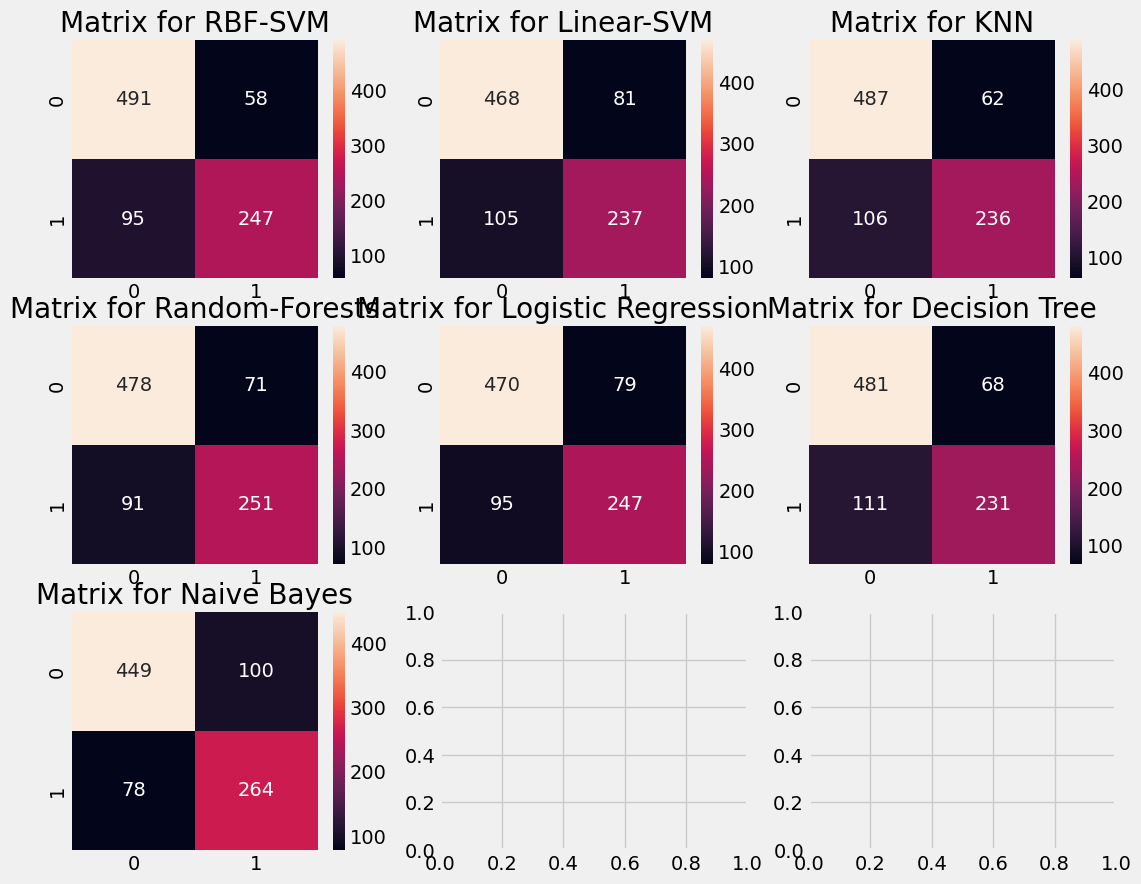

In [62]:
# 여러 분류 모델에 대해 10-Fold 교차 검증을 수행한 뒤, Confusion Matrix를 시각화
# confusion matrix는 각 모델이 정답을 얼마나 잘 맞췄는지, 어떤 클래스에서 틀렸는지 구체적으로 보여준다.

# 총 9개의 subplot 공간 확보
f, ax = plt.subplots(3, 3, figsize=(12, 10))

# (1) RBF 커널 SVM
y_pred = cross_val_predict(svm.SVC(kernel='rbf'), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[0, 0], annot=True, fmt='2.0f')
ax[0, 0].set_title('Matrix for RBF-SVM')

# (2) 선형 커널 SVM
y_pred = cross_val_predict(svm.SVC(kernel='linear'), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[0, 1], annot=True, fmt='2.0f')
ax[0, 1].set_title('Matrix for Linear-SVM')

# (3) K-최근접 이웃
y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[0, 2], annot=True, fmt='2.0f')
ax[0, 2].set_title('Matrix for KNN')

# (4) 랜덤 포레스트
y_pred = cross_val_predict(RandomForestClassifier(n_estimators=100), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[1, 0], annot=True, fmt='2.0f')
ax[1, 0].set_title('Matrix for Random-Forests')

# (5) 로지스틱 회귀
y_pred = cross_val_predict(LogisticRegression(), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[1, 1], annot=True, fmt='2.0f')
ax[1, 1].set_title('Matrix for Logistic Regression')

# (6) 결정 트리
y_pred = cross_val_predict(DecisionTreeClassifier(), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[1, 2], annot=True, fmt='2.0f')
ax[1, 2].set_title('Matrix for Decision Tree')

# (7) 나이브 베이즈
y_pred = cross_val_predict(GaussianNB(), X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, y_pred), ax=ax[2, 0], annot=True, fmt='2.0f')
ax[2, 0].set_title('Matrix for Naive Bayes')

plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

#### Interpreting Confusion Matrix

왼쪽 대각선(↘)은 각 클래스에 대해 정확하게 예측한 수를 나타냄  
오른쪽 대각선(↙)은 잘못 예측한 수를 나타냄

RBF-SVM 모델의 행렬을 통해 자세히 살펴보자.

1. 정확하게 예측한 수
    - 사망자 예측 정확: 491명
    - 생존자 예측 정확: 247명
        
        → 총 정확 예측 수: 491 + 247 = **738명**
        
        → 평균 교차 검증 정확도는 738 / 891 = **약 82.8%**
        
        → 이는 이전에 계산한 정확도와 일치한다.
        
2. 오류 분석 (Errors)
    - 실제로는 사망했는데 생존으로 잘못 분류된 사람: **58명**
    - 실제로는 생존했는데 사망으로 잘못 분류된 사람: **95명**
        
        → 즉, 생존을 사망으로 잘못 예측한 경우가 더 많았다.
        
<br>

전체 모델들의 혼동 행렬을 비교해보면

- RBF-SVM은 **사망한 승객**을 더 잘 예측하는 경향이 있으며,
- Naive Bayes는 **생존한 승객**을 더 잘 예측하는 경향이 있다.

## Hyper-Parameters Tuning

머신러닝 모델은 일종의 블랙박스(Black-Box)와 같다.
이 블랙박스에는 기본적으로 설정된 여러 파라미터 값들이 존재하며, 이 값들을 조정(tune)하거나 변경(change)함으로써 더 나은 모델을 만들 수 있다.

<br>

예를 들어,

SVM(Support Vector Machine) 모델에서는 C와 gamma 같은 값들이 하이퍼파라미터이다.

이와 마찬가지로, 각 분류기(classifier)마다 고유한 하이퍼파라미터들이 존재한다.

이러한 **하이퍼파라미터(hyper-parameters)**는
모델의 학습률(learning rate)이나 학습 방식에 영향을 주며,
이들을 조정하여 알고리즘의 성능을 개선하는 작업을 **하이퍼파라미터 튜닝(hyper-parameter tuning)**이라고 합니다.

<br>

이번에는 위에서 살펴본 분류기들 중 성능이 가장 좋았던 SVM과 Random Forests의 하이퍼파라미터를 튜닝해 보겠다.

### Hyper-Parameters Tuning: SVM

In [63]:
# GridSearchCV를 활용하여 SVM 모델의 하이퍼파라미터 튜닝

from sklearn.model_selection import GridSearchCV

# 탐색할 C (정규화 강도) 값들
C = [0.05, 0.1, 0.2, 0.3, 0.25, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# 탐색할 gamma (감마값 - 결정 경계의 유연성 제어) 값들
gamma = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# 탐색할 커널
kernel = ['rbf', 'linear']

# 하이퍼파라미터 조합 정의
hyper = {'kernel': kernel, 'C': C, 'gamma': gamma}

# GridSearchCV를 생성 (SVM 분류기를 기반으로, 위에서 정의한 하이퍼파라미터 탐색)
gd = GridSearchCV(estimator=svm.SVC(), param_grid=hyper, verbose=True)

# 전체 데이터를 대상으로 학습 (교차 검증 포함)
gd.fit(X, Y)

# 최적의 평균 교차 검증 정확도
print(gd.best_score_)

# 최적의 하이퍼파라미터 조합을 적용한 모델
print(gd.best_estimator_)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
0.8282593685267716
SVC(C=0.4, gamma=0.3)


GridSearchCV는 주어진 파라미터 조합을 모두 테스트하여 가장 좋은 성능을 보이는 모델을 찾아준다.

이때 내부적으로 교차 검증을 수행하여 과적합 방지 및 일반화 성능 향상 효과도 있다.

verbose=True로 설정하면 각 조합을 탐색하는 과정을 콘솔에서 출력해 준다.

### Hyper-Parameters Tuning: Random Forests

In [64]:
# Random Forest의 n_estimators 하이퍼파라미터 튜닝을 위한 GridSearchCV 설정

# 탐색할 트리 개수(n_estimators) 범위 지정: 100부터 900까지, 100 단위 증가
n_estimators = range(100, 1000, 100)

# 탐색할 하이퍼파라미터 딕셔너리 정의
hyper = {'n_estimators': n_estimators}

# GridSearchCV 객체 생성
# - estimator: 랜덤 포레스트 분류기
# - param_grid: 탐색할 하이퍼파라미터들
# - verbose=True: 탐색 과정 출력
gd = GridSearchCV(
    estimator=RandomForestClassifier(random_state=0),
    param_grid=hyper,
    verbose=True
)

# 전체 데이터(X, Y)를 사용하여 그리드 탐색 수행
gd.fit(X, Y)

# 최적의 평균 교차 검증 정확도
print(gd.best_score_)

# 최적의 하이퍼파라미터 조합으로 구성된 모델
print(gd.best_estimator_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
0.819327098110602
RandomForestClassifier(n_estimators=300, random_state=0)


최고 정확도는

RBF-SVM의 경우 **82.82%**였으며, 이때의 하이퍼파라미터는 C=0.4, gamma=0.3이었다.   
Random Forest의 경우 n_estimators=300일 때 정확도는 약 **81.93%**였다.

## Ensembling

앙상블(Ensembling)은 모델의 정확도나 성능을 향상시키는 좋은 방법이다. 간단히 말하면, 여러 개의 단순한 모델들을 조합하여 하나의 강력한 모델을 만드는 것이다.

예를 들어, 어떤 휴대폰을 사려고 할 때 여러 사람들에게 다양한 기준으로 조언을 구한다고 생각해보자. 각각의 의견을 종합하면 특정 제품에 대한 강력한 판단을 내릴 수 있을 것이다. 이것이 바로 앙상블이며, 모델의 안정성(stability)을 높여주는 역할을 한다.

앙상블에는 다음과 같은 방식들이 있다.

- Voting Classifier

- Bagging

- Boosting

<br>

앙상블 기법은 하나의 복잡한 모델을 만드는 것이 아니라, 여러 개의 weak learners들을 결합하여 보다 안정적이고 성능 좋은 모델을 만드는 전략이다.

예측의 정확도 향상, 과적합 방지, 일반화 성능 개선에 효과적이다.

### a. Voting Classifier

Voting Classifier(투표 기반 분류기)는 여러 개의 서로 다른 간단한 머신러닝 모델들의 예측 결과를 결합하는 가장 단순한 방법이다.  

이 방식은 모든 서브 모델들의 예측을 기반으로 평균적인 예측 결과를 제공한다. 이때 사용되는 서브 모델(또는 기본 모델, base models) 들은 서로 다른 종류의 알고리즘을 사용한다.

개별 모델들의 성능이 비슷할 때, 그 예측을 평균 내거나 다수결로 조합하면 더 안정적이고 신뢰도 높은 결과를 낼 수 있다.

In [65]:
from sklearn.ensemble import VotingClassifier

# 앙상블 모델 생성
ensemble_lin_rbf = VotingClassifier(
    estimators=[
        ('KNN', KNeighborsClassifier(n_neighbors=10)),                       # K-최근접 이웃
        ('RBF', svm.SVC(probability=True, kernel='rbf', C=0.5, gamma=0.1)),  # RBF 커널 SVM (확률 출력 활성화)
        ('RFor', RandomForestClassifier(n_estimators=500, random_state=0)),  # 랜덤 포레스트
        ('LR', LogisticRegression(C=0.05)),                                  # 로지스틱 회귀
        ('DT', DecisionTreeClassifier(random_state=0)),                      # 결정 트리
        ('NB', GaussianNB()),                                                # 가우시안 나이브 베이즈
        ('svm', svm.SVC(kernel='linear', probability=True))                  # 선형 SVM (확률 출력 활성화)
    ],
    voting='soft'  # sof voting: 예측 확률의 평균을 기반으로 최종 예측
).fit(train_X, train_Y)

# 테스트 세트에 대한 정확도 출력
print('The accuracy for ensembled model is:', ensemble_lin_rbf.score(test_X, test_Y))

# 10-Fold Cross Validation을 통해 모델 일반화 성능 평가
cross = cross_val_score(ensemble_lin_rbf, X, Y, cv=10, scoring="accuracy")

# 평균 교차 검증 정확도 출력
print('The cross validated score is', cross.mean())

The accuracy for ensembled model is: 0.8171641791044776
The cross validated score is 0.8249188514357053


### b. Bagging

Bagging은 일반적인 앙상블 기법이다.

데이터셋을 작은 부분 집합들로 나누고, 그 각각에 대해 **동일한 분류기(classifier)**를 적용한 다음, 모든 예측값의 평균을 취하는 방식으로 작동한다. 이러한 평균화 과정으로 인해 분산(variance)이 감소하게 된다.

Voting Classifier와는 다르게, Bagging은 같은 종류의 분류기를 사용한다. Voting Classifier가 서로 다른 모델을 조합하는 반면, Bagging은 같은 모델을 여러 번 훈련시켜 사용한다.

#### Bagged KNN

Bagging은 분산(variance)이 높은 모델에서 가장 잘 작동합니다.
이러한 예시로는 Decision Tree나 랜덤 포레스트(Random Forest)를 들 수 있다.

우리는 **K-최근접 이웃(KNN)**도 사용할 수 있는데, 이때는 이웃의 수(n_neighbors)가 작은 경우에 해당된다.
즉, 이웃 수가 작을수록 분산이 높기 때문에, KNN도 배깅 기법과 잘 어울릴 수 있다.

<br>

KNN 알고리즘을 기반으로 한 Bagging 앙상블 모델을 만들고, 단순한 모델보다 일반화된 성능을 얻기 위해 교차 검증 결과까지 함께 출력해 보자.

In [66]:
from sklearn.ensemble import BaggingClassifier

# KNN을 기반으로 한 Bagging 앙상블 모델 생성
model = BaggingClassifier(
    estimator=KNeighborsClassifier(n_neighbors=3),  # base_estimator → estimator
    n_estimators=700,           # 총 700개의 모델을 배깅으로 구성
    random_state=0              # 결과 재현성을 위한 시드 고정
)

# 모델 학습
model.fit(train_X, train_Y)

# 테스트 데이터에 대해 예측 수행
prediction = model.predict(test_X)

# 정확도 출력
print('The accuracy for bagged KNN is:', metrics.accuracy_score(prediction, test_Y))

# 10-Fold 교차 검증 수행 및 평균 정확도 출력
result = cross_val_score(model, X, Y, cv=10, scoring='accuracy')
print('The cross validated score for bagged KNN is:', result.mean())

The accuracy for bagged KNN is: 0.832089552238806
The cross validated score for bagged KNN is: 0.8104244694132333


#### Bagged Decision Tree

In [67]:
# Descision Tree를 기반으로 한 Bagging 모델 생성
# - estimator: 개별 학습기로 사용할 Decision Tree
# - n_estimators: 100개의 트리를 앙상블
# - random_state: 재현 가능성 확보
model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100, random_state=0)

# 모델 학습
model.fit(train_X, train_Y)

# 테스트 데이터 예측
prediction = model.predict(test_X)

# 테스트 정확도 출력
print('The accuracy for bagged Decision Tree is:', metrics.accuracy_score(test_Y, prediction))

# 교차 검증 수행 (10-fold)
result = cross_val_score(model, X, Y, cv=10, scoring='accuracy')

# 교차 검증 평균 정확도 출력
print('The cross validated score for bagged Decision Tree is:', result.mean())

The accuracy for bagged Decision Tree is: 0.8208955223880597
The cross validated score for bagged Decision Tree is: 0.8171410736579275


### c. Boosting

Boosting은 classifier를 순차적으로 학습시키는 앙상블 기법입니다. 약한 모델을 점진적으로 개선하여 강한 모델을 만들어내는 방식이다.

- 작동 방식

1. 먼저 전체 데이터셋을 사용하여 초기 모델을 학습시킨다.

2. 이 모델은 일부 데이터를 올바르게 분류하고, 일부는 잘못 분류하게 된다.

3. 다음 반복(iteration)에서는 잘못 예측된 샘플들에 더 많은 가중치(weight)를 부여하여, 다음 분류기가 이 샘플들을 더 잘 학습하도록 유도한다.

4. 이 과정을 반복하면서 새로운 분류기를 계속 추가하고, 모델 성능이 어느 정도에 도달하면 학습을 멈춘다.

<br>

즉, Boosting은 이전 분류기의 오류를 보완해가며 학습하는 방식으로, 최종적으로는 정확도와 성능이 향상된 강력한 모델을 구축할 수 있도록 돕는 방법이다.

#### AdaBoost(Adaptive Boosting)

여기에서 사용되는 약한 학습기(weak learner) 또는 추정기(estimator)는 **Decision Tree**이다.  
기본 설정된 base_estimator는 우리가 원하는 어떤 알고리즘으로든 변경할 수 있다.

In [68]:
# AdaBoostClassifier를 활용한 모델 성능 평가

from sklearn.ensemble import AdaBoostClassifier

# AdaBoostClassifier 설정
# - n_estimators: 사용할 약한 학습기(기본은 Decision Tree)의 개수
# - random_state: 결과 재현을 위한 시드 고정
# - learning_rate: 각 약한 학습기의 학습률 (작을수록 보수적으로 학습)
ada = AdaBoostClassifier(n_estimators=200, random_state=0, learning_rate=0.1)

# 교차 검증(cross-validation)을 통해 모델 성능 평가
# - X: 입력 피처 / Y: 타깃 레이블
# - cv=10: 10-Fold 교차 검증
# - scoring='accuracy': 정확도를 기준으로 평가
result = cross_val_score(ada, X, Y, cv=10, scoring='accuracy')

# 평균 정확도 출력
print('The cross validated score for AdaBoost is:', result.mean())

The cross validated score for AdaBoost is: 0.8136828963795256


#### Stochastic Gradient Boosting

여기에서도 사용되는 weak learner도 마찬가지로 Decision Tree이다.

In [69]:
# Gradient Boosting 모델을 정의하고, 교차 검증을 통해 평균 정확도 측정

from sklearn.ensemble import GradientBoostingClassifier

# GradientBoostingClassifier 설정
grad = GradientBoostingClassifier(n_estimators=500, random_state=0, learning_rate=0.1)

# 10-Fold 교차 검증을 통해 모델의 평균 정확도 평가
result = cross_val_score(grad, X, Y, cv=10, scoring='accuracy')

# 평균 정확도 출력
print('The cross validated score for Gradient Boosting is:', result.mean())

The cross validated score for Gradient Boosting is: 0.8115230961298376


#### XGBoost

In [70]:
# XGBoost 모델 정의 및 10-Fold 교차 검증을 통한 성능 평가

import xgboost as xg

# XGBClassifier 설정
xgboost = xg.XGBClassifier(n_estimators=900, learning_rate=0.1, random_state=0)
# random_state=0이 누락되었었음 ..

# 10-Fold 교차 검증으로 정확도 평가
result = cross_val_score(xgboost, X, Y, cv=10, scoring='accuracy')

# 평균 정확도 출력
print('The cross validated score for XGBoost is:', result.mean())

The cross validated score for XGBoost is: 0.8160299625468165


하이퍼파라미터 튜닝을 통해 이 정확도를 더 높여보려고 한다.

### Hyper-Parameter Tuning for AdaBoost

In [71]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

n_estimators = list(range(100,1100,100))
learn_rate = [0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
hyper = {'n_estimators': n_estimators, 'learning_rate': learn_rate}

gd = GridSearchCV(
    estimator=AdaBoostClassifier(),
    param_grid=hyper,
    # cv=3,
    # n_jobs=-1,
    verbose=True
)
gd.fit(X, Y)

print(gd.best_score_)
print(gd.best_estimator_)


Fitting 5 folds for each of 120 candidates, totalling 600 fits
0.8293892411022534
AdaBoostClassifier(learning_rate=0.4, n_estimators=800)


AdaBoost를 사용해 얻을 수 있는 최대 정확도는 82.93%이며,  
해당 결과는 n_estimators=800과 learning_rate=0.4일 때 나온 값이다.

### Confusion Matrix for the Best Model

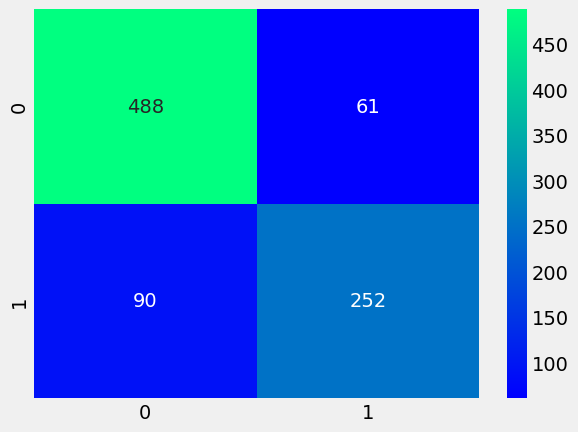

In [72]:
# 최적의 하이퍼파라미터로 AdaBoost 분류기 생성
ada = AdaBoostClassifier(n_estimators=800, random_state=0, learning_rate=0.4)

# 교차 검증을 통해 전체 데이터셋에 대한 예측값 생성 (cv=10: 10-Fold Cross Validation)
result = cross_val_predict(ada, X, Y, cv=10)

# 예측값과 실제값을 바탕으로 Confusion Matrix 생성 및 시각화
sns.heatmap(confusion_matrix(Y, result), cmap='winter', annot=True, fmt='2.0f')

plt.show()

## Feature Importance

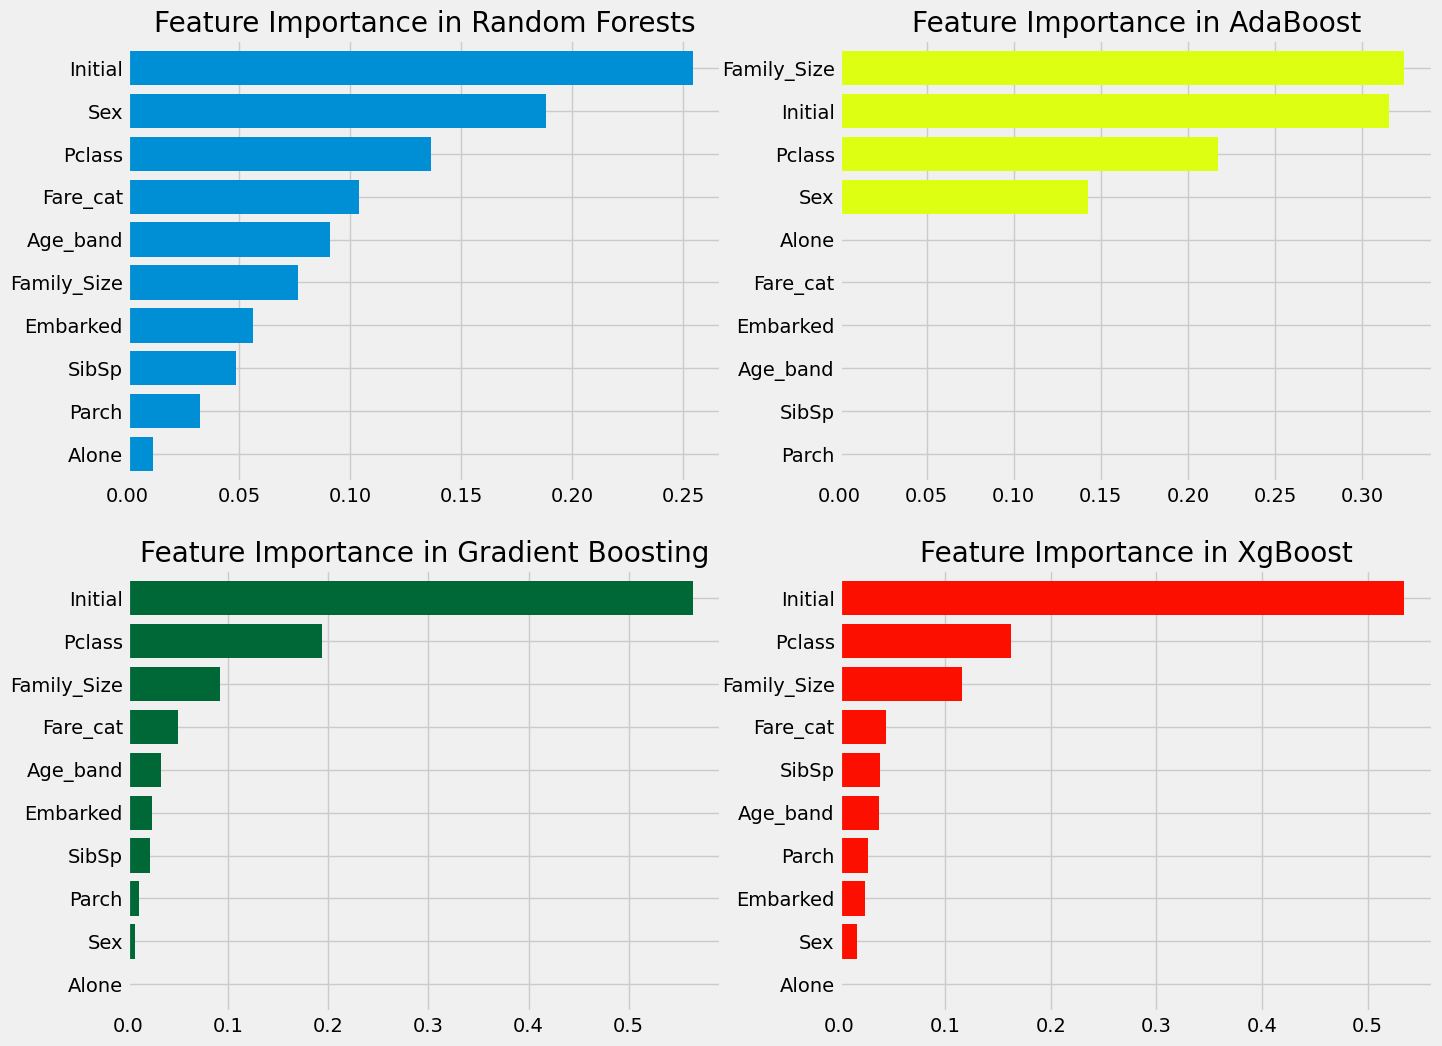

In [77]:
# 다양한 분류 모델에서 Feature Importance(변수 중요도)를 시각화
# 모델: Random Forest, AdaBoost, Gradient Boosting, XGBoost 사용

f, ax = plt.subplots(2, 2, figsize=(15, 12))

# (1) Random Forest를 사용한 Feature Importance 시각화
model = RandomForestClassifier(n_estimators=500, random_state=0)
model.fit(X, Y)
pd.Series(model.feature_importances_, X.columns) \
  .sort_values(ascending=True) \
  .plot.barh(width=0.8, ax=ax[0, 0])
ax[0, 0].set_title('Feature Importance in Random Forests')

# (2) AdaBoost를 사용한 Feature Importance 시각화
model = AdaBoostClassifier(n_estimators=200, learning_rate=0.05, random_state=0)
model.fit(X, Y)
pd.Series(model.feature_importances_, X.columns) \
  .sort_values(ascending=True) \
  .plot.barh(width=0.8, ax=ax[0, 1], color='#ddff11')
ax[0, 1].set_title('Feature Importance in AdaBoost')

# (3) Gradient Boosting을 사용한 Feature Importance 시각화
model = GradientBoostingClassifier(n_estimators=500, learning_rate=0.1, random_state=0)
model.fit(X, Y)
pd.Series(model.feature_importances_, X.columns) \
  .sort_values(ascending=True) \
  .plot.barh(width=0.8, ax=ax[1, 0], cmap='RdYlGn_r')  # 컬러맵 지정
ax[1, 0].set_title('Feature Importance in Gradient Boosting')

# (4) XGBoost를 사용한 Feature Importance 시각화
model = xg.XGBClassifier(n_estimators=900, learning_rate=0.1, random_state=0)
model.fit(X, Y)
pd.Series(model.feature_importances_, X.columns) \
  .sort_values(ascending=True) \
  .plot.barh(width=0.8, ax=ax[1, 1], color='#FD0F00')  # 빨간색 계열
ax[1, 1].set_title('Feature Importance in XgBoost')

plt.show()

RandomForests, AdaBoost 등 여러 분류기에서 중요한 특성들을 확인할 수 있다.

#### 관찰 내용 (Observations)  

전반적으로 봤을 때 Sex는 대부분의 모델에서 중요하지 않은 것으로 보인다.    
- 이는 약간 충격적인데, 왜냐하면 앞서 확인했듯이 Sex와 Pclass를 결합했을 때 매우 좋은 분류 기준이 되었기 때문이다.
실제로 Sex는 RandomForest에서만 중요하게 나타난다.

- 대신 Initial 특성이 여러 분류기에서 가장 중요한 피처 중 하나로 나타나고 있다.  
이전에 Sex와 Initial 사이에 양의 상관관계가 있다는 걸 확인한 바 있는데,
이는 결국 둘 다 성별을 나타내는 변수라는 것을 의미한다.

이와 유사하게, Pclass와 Fare_cat은 승객의 사회적 지위를,   
Family_Size는 Alone, Parch, SibSp와 함께 가족 구성을 나타낸다.

<br>

왜 Sex는 일부 모델에서만 중요할까?  

Sex는 male/female로 단순한 이진 피처이다.

일부 모델(특히 트리 기반 앙상블)은 다른 파생 피처(Initial, Pclass, Fare_cat)에 이미 성별의 정보가 간접적으로 녹아 있다면, Sex 자체는 덜 중요하게 여길 수 있다.

특히 Initial이 'Mr', 'Mrs', 'Miss' 등을 통해 성별을 이미 반영하고 있기 때문에 RandomForest 모델 외의 나머지 모델에서는 상대적으로 무시되고 있는 것이다.

